## Steer Function Comparison
In this notebook, we examine the planners using different steer functions.

In [13]:
%load_ext autoreload
%autoreload 2
from mpb import MPB, MultipleMPB
from plot_stats import plot_planner_stats, plot_smoother_stats
from utils import latexify
from table import latex_table
from definitions import *
import matplotlib as mpl
import sys, os
mpl.rcParams['mathtext.fontset'] = 'cm'
# make sure to not use Level-3 fonts
mpl.rcParams['pdf.fonttype'] = 42
import matplotlib.pyplot as plt
from copy import deepcopy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Polygon Environments

In [60]:
time_limit_multiplier = 1
steer_function_times = [
    ('reeds_shepp', 15 * time_limit_multiplier),    
    ('dubins', 45 * time_limit_multiplier),    
    ('cc_reeds_shepp', 1.5 * 60 * time_limit_multiplier),    
    ('posq', 120 * time_limit_multiplier)
]

In [61]:
pools = {}
def benchmark_polygon(scenario: str, start: {str: float}, goal: {str: float}, robot_model: str = None):
    bench = "polygon_%s" % scenario
    
    pool = MultipleMPB()
    # config = MPB.get_config()
    for steer_function, time_limit in steer_function_times:
        m = MPB()   
        # m.update(deepcopy(config))
        m["max_planning_time"] = time_limit
        m["env.start"] = start
        m["env.goal"] = goal
        m["env.type"] = "polygon"
        m["env.polygon.source"] = "polygon_mazes/%s.svg" % scenario
        if robot_model:
            print("Using robot model %s." % robot_model)
            m["env.collision.robot_shape_source"] = robot_model
        m["benchmark.planning.sbpl_adstar"] = False
        m["benchmark.planning.sbpl_anastar"] = False
        m["benchmark.planning.sbpl_arastar"] = False
        m["benchmark.planning.sbpl_lazy_ara"] = False
        m["benchmark.planning.sbpl_mha"] = False
        m.set_steer_functions([steer_function])
        #     m.set_smoothers(['grips', 'ompl_bspline', 'ompl_shortcut', 'ompl_simplify_max'])
        #     m.set_planners(['theta_star'])
        #     m.set_planners(['sbpl_adstar'])
        pool.benchmarks.append(m)
    pools[scenario] = pool
    run_result = pool.run_parallel(bench, processes=20, limit_memory=True)
    return run_result

In [21]:
def generate_plots(scenario: str, start: {str: float}, goal: {str: float}, robot_model: str = None):
    bench = "polygon_%s" % scenario
    pool = pools[scenario]
    for i, (steer_function, _) in enumerate(steer_function_times):
        bench_steer = "%s_%s" % (bench, steer_function)
        # plot trajectories
        try:
            pool.benchmarks[i].visualize_trajectories(show_legend=True, fig_width=8, fig_height=8)
            plt.savefig("%s/%s_trajectories.pdf" % (bench, bench_steer), bbox_inches='tight')
        except Exception as e:
            print("Error while visualizing trajectories:", e, file=sys.stderr)

        # plot planner stats
        try:        
            plot_planner_stats(pool.benchmarks[i].results_filename, save_file="%s/%s_stats.pdf" % (bench, bench_steer))
        except Exception as e:
            print("Error while plotting planner statistics:", e, file=sys.stderr)

        # plot smoother stats
        try:
            plot_smoother_stats(pool.benchmarks[i].results_filename,
                                save_file="%s/%s_smoother_stats.pdf" % (bench, bench_steer),
                                separate_planners=False, num_colors=8,
                                combine_views=True, max_plots_per_line=3)
        except Exception as e:
            print("Error while plotting smoother statistics:", e, file=sys.stderr)

        # plot smoother stats (separated by planners)
        try:
            plot_smoother_stats(pool.benchmarks[i].results_filename,
                                save_file="%s/%s_smoother_stats_separated.pdf" % (bench, bench_steer),
                                separate_planners=True, num_colors=8, combine_views=True,
                                max_plots_per_line=1, fig_width=25, fig_height=6)
        except Exception as e:
            print("Error while plotting smoother statistics:", e, file=sys.stderr)

        # generate LaTeX table
        try:
            with open("%s/%s_table.txt" % (bench, bench_steer), 'w') as tf:
                tf.write(latex_table(pool.benchmarks[i].results_filename,
                                     row_label='\\textbf{Steer function: \\texttt{%s}} (\\SI{%.1f}{\\minute} time limit)'

                                     % (latexify(steer_function_names[steer_function]),
                                        time_limit/60),
                                     time_limit=time_limit))
        except Exception as e:
            print("Error while generating table:", e, file=sys.stderr)

Available memory: 96.02 GB, limiting each MPB process to 6.9% usage (6.67 GB).
Creating pool of 4 processes.
Created MPB from config polygon_parking1_0/polygon_parking1_0_0_config.json.
Created MPB from config polygon_parking1_0/polygon_parking1_0_2_config.json.
Created MPB from config polygon_parking1_0/polygon_parking1_0_3_config.json.
Created MPB from config polygon_parking1_0/polygon_parking1_0_1_config.json.
Running MPB with ID polygon_parking1_0_2 (log file at polygon_parking1_0/polygon_parking1_0_2.log)...
Running MPB with ID polygon_parking1_0_0 (log file at polygon_parking1_0/polygon_parking1_0_0.log)...
Running MPB with ID polygon_parking1_0_3 (log file at polygon_parking1_0/polygon_parking1_0_3.log)...
Running MPB with ID polygon_parking1_0_1 (log file at polygon_parking1_0/polygon_parking1_0_1.log)...



Benchmark 2 (polygon_parking1_0_2) finished successfully.


Benchmark 3 (polygon_parking1_0_3) finished successfully.
Benchmark 1 (polygon_parking1_0_1) finished successfully.

Benchmark 0 (polygon_parking1_0_0) finished successfully.
All benchmarks succeeded.
Visualizing polygon_parking1_0/polygon_parking1_0_0_results.json
Planner OMPL found no solution!
Planner Theta* found no solution!


/root/code/mpb/plotting/plot_aggregate.py:95: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0, right=0
  plt.gca().set_xlim([0, len(planners)])
Error while plotting benchmark progress overview.
/root/code/mpb/plotting/trajectory.py:73: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  
/root/code/mpb/plotting/plot_env.py:113: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  plt.gca().set_xlim([env["min_x"], env["max_x"]])
/root/code/mpb/plotting/plot_env.py:114: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  plt.gca().set_ylim([env["min_y"], env["max_y"]])
/root/code/mpb/plotting/trajectory.py:221: UserWarning: Attempting to set identical left==right results
in singular transformations; automaticall

Visualizing polygon_parking1_0/polygon_parking1_0_0_results.json...
Saved polygon_parking1_0/polygon_parking1_0_reeds_shepp_stats.pdf.


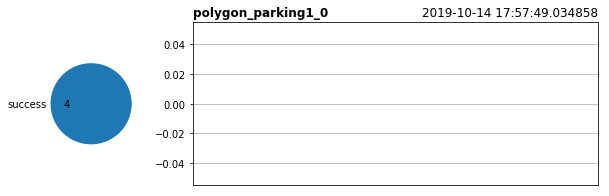

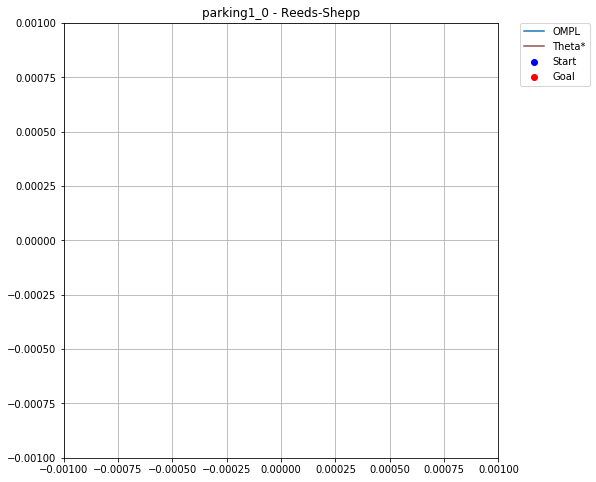

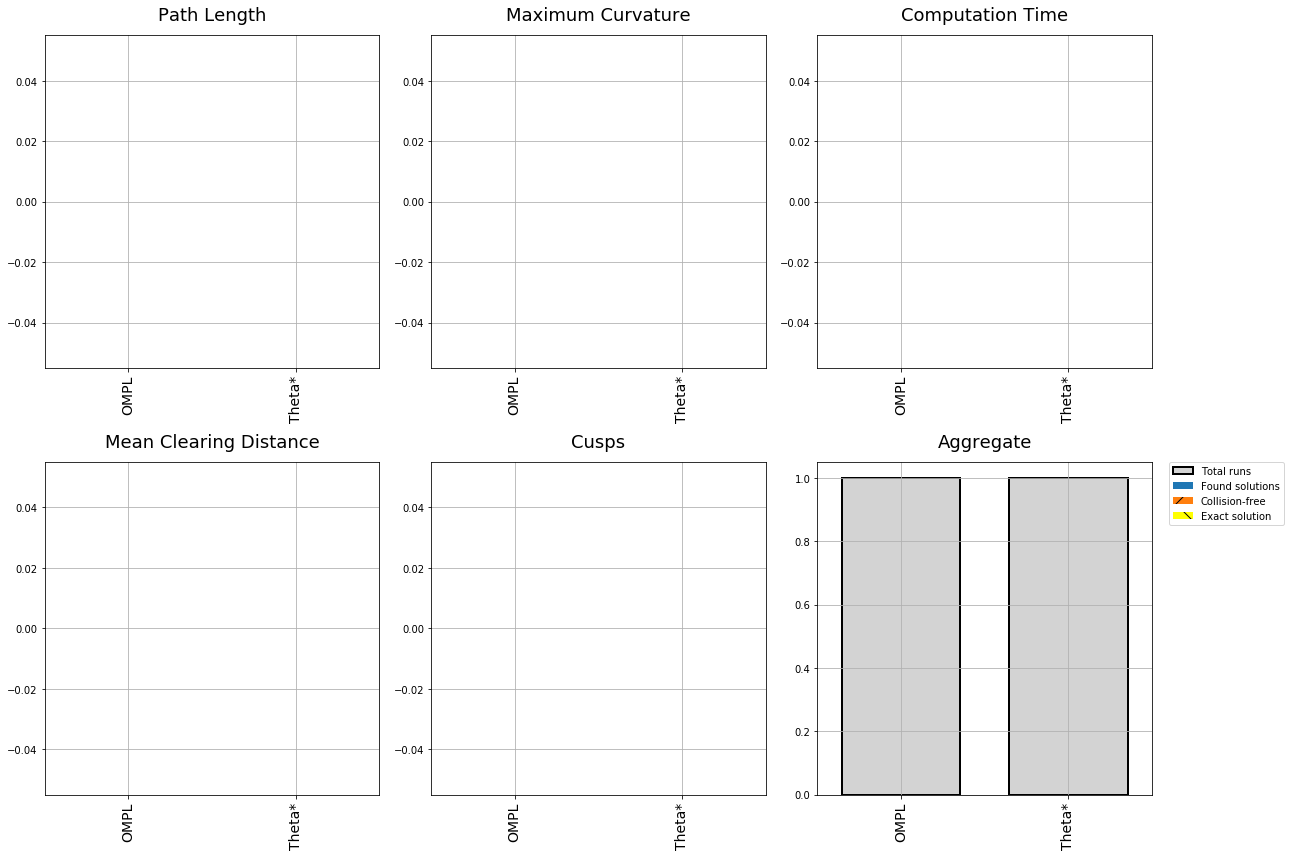

Visualizing polygon_parking1_0/polygon_parking1_0_1_results.json
Planner OMPL found no solution!
Planner Theta* found no solution!


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
Error while generating table: zero-size array to reduction operation maximum which has no identity


Visualizing polygon_parking1_0/polygon_parking1_0_1_results.json...
Saved polygon_parking1_0/polygon_parking1_0_dubins_stats.pdf.


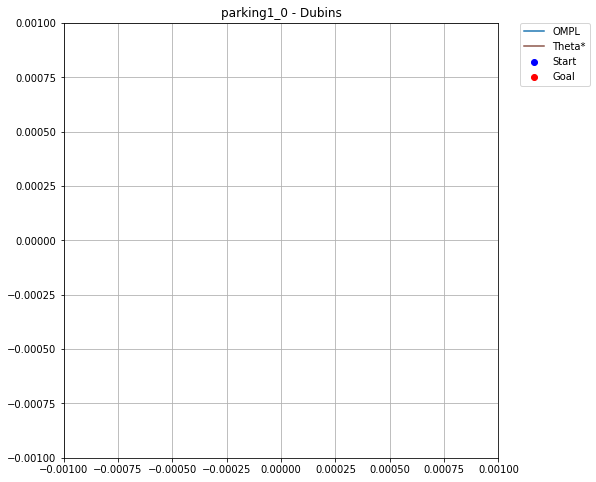

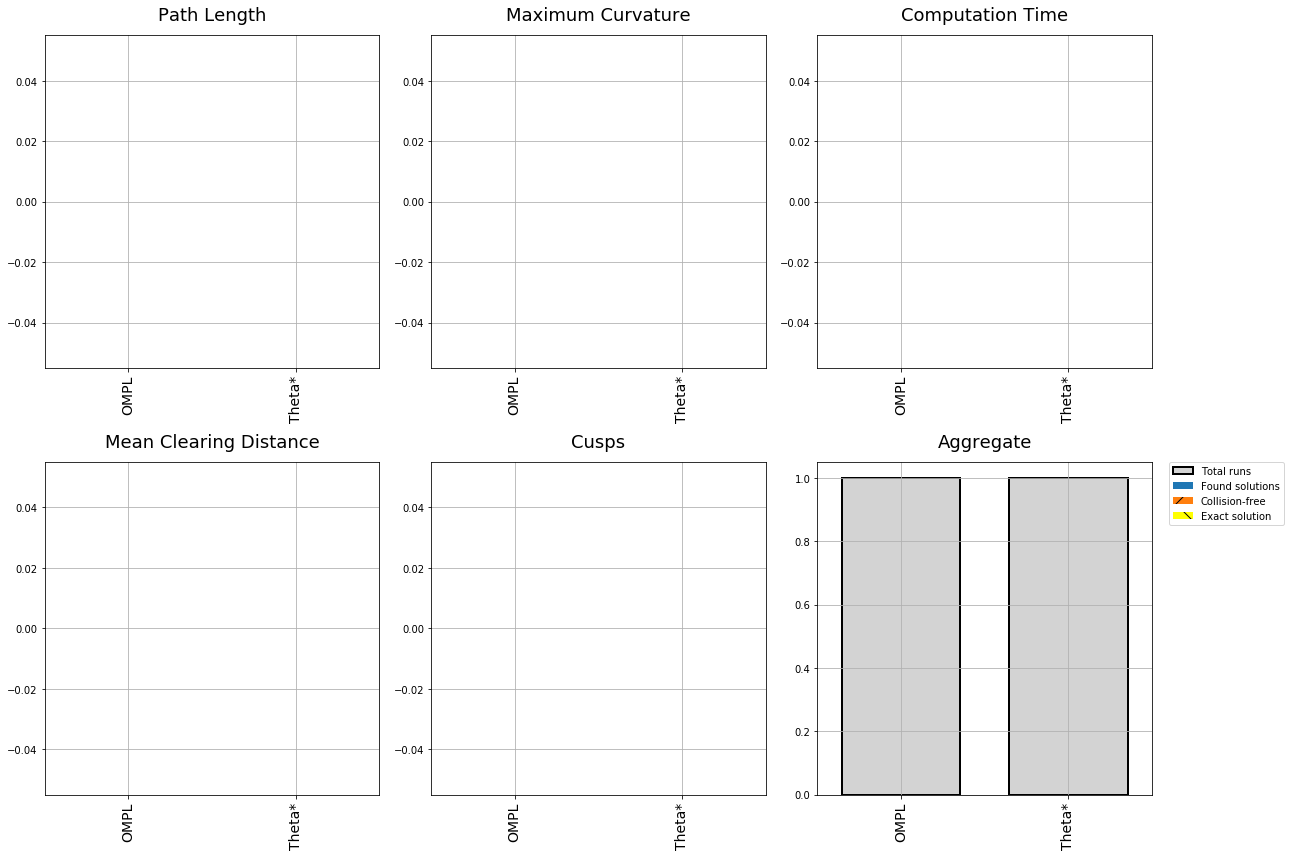

Visualizing polygon_parking1_0/polygon_parking1_0_2_results.json
Planner OMPL found no solution!
Planner Theta* found no solution!


Error while generating table: zero-size array to reduction operation maximum which has no identity


Visualizing polygon_parking1_0/polygon_parking1_0_2_results.json...
Saved polygon_parking1_0/polygon_parking1_0_cc_reeds_shepp_stats.pdf.


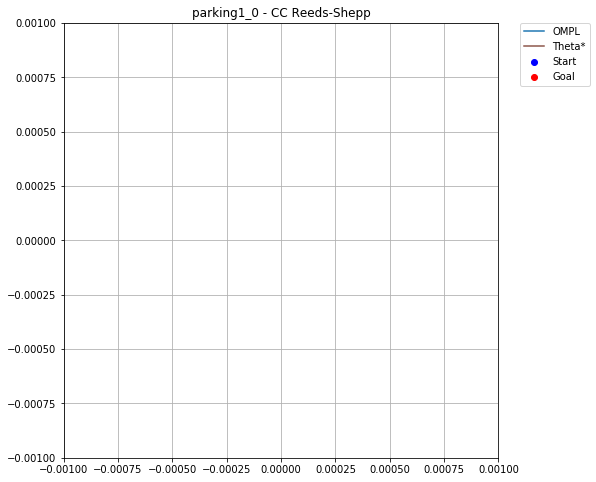

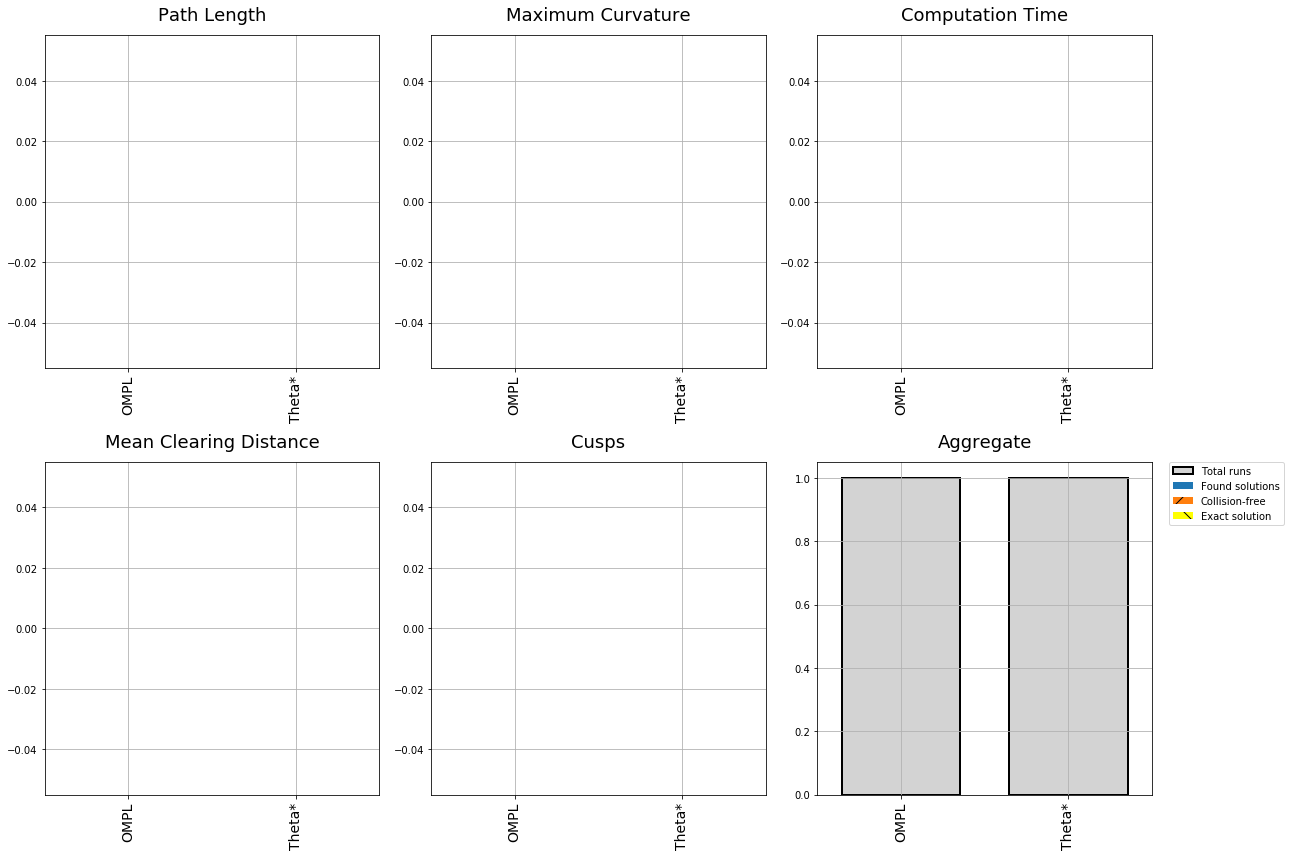

Visualizing polygon_parking1_0/polygon_parking1_0_3_results.json
Planner OMPL found no solution!
Planner Theta* found no solution!


Error while generating table: zero-size array to reduction operation maximum which has no identity


Visualizing polygon_parking1_0/polygon_parking1_0_3_results.json...
Saved polygon_parking1_0/polygon_parking1_0_posq_stats.pdf.


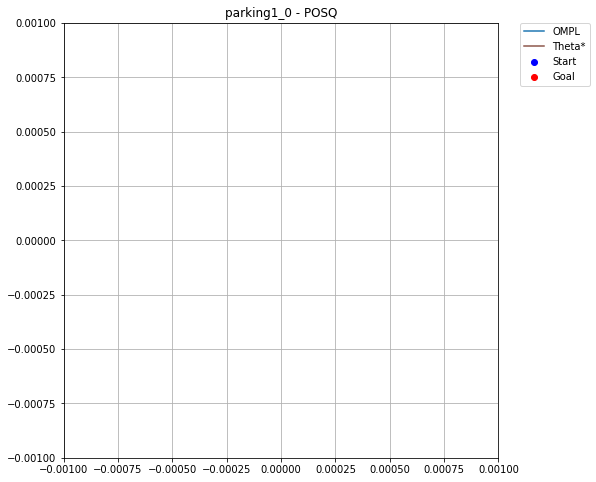

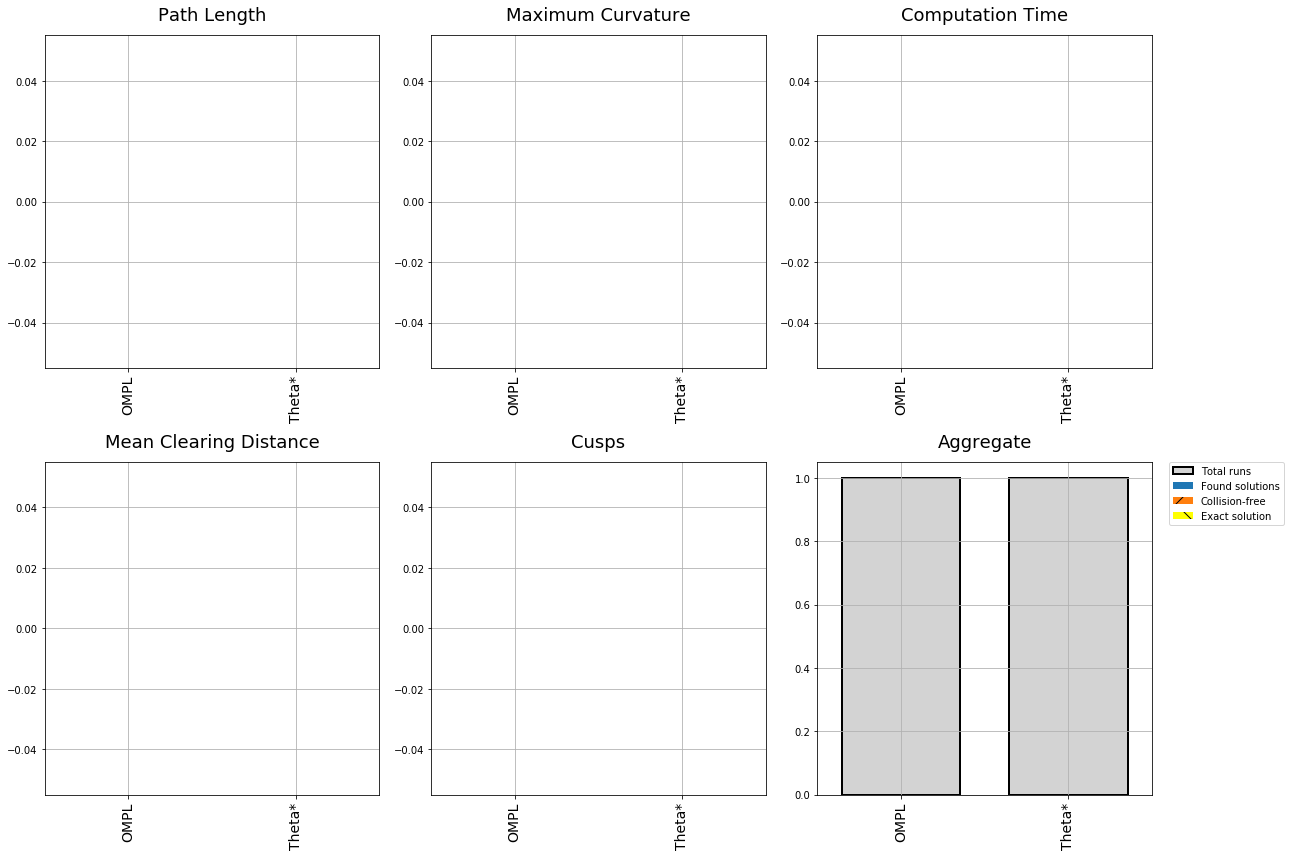

Available memory: 96.01 GB, limiting each MPB process to 6.9% usage (6.67 GB).
Creating pool of 4 processes.


Error while generating table: zero-size array to reduction operation maximum which has no identity


Created MPB from config polygon_parking1_1/polygon_parking1_1_0_config.json.
Created MPB from config polygon_parking1_1/polygon_parking1_1_2_config.json.
Created MPB from config polygon_parking1_1/polygon_parking1_1_1_config.json.
Created MPB from config polygon_parking1_1/polygon_parking1_1_3_config.json.
Running MPB with ID polygon_parking1_1_2 (log file at polygon_parking1_1/polygon_parking1_1_2.log)...
Running MPB with ID polygon_parking1_1_0 (log file at polygon_parking1_1/polygon_parking1_1_0.log)...
Running MPB with ID polygon_parking1_1_3 (log file at polygon_parking1_1/polygon_parking1_1_3.log)...
Running MPB with ID polygon_parking1_1_1 (log file at polygon_parking1_1/polygon_parking1_1_1.log)...



Benchmark 0 (polygon_parking1_1_0) finished successfully.

Benchmark 2 (polygon_parking1_1_2) finished successfully.

Benchmark 3 (polygon_parking1_1_3) finished successfully.

Benchmark 1 (polygon_parking1_1_1) finished successfully.
All benchmarks succeeded.
Visualizing polygon_parking1_1/polygon_parking1_1_0_results.json
Planner OMPL found no solution!
Planner Theta* found no solution!


Error while plotting benchmark progress overview.


Visualizing polygon_parking1_1/polygon_parking1_1_0_results.json...
Saved polygon_parking1_1/polygon_parking1_1_reeds_shepp_stats.pdf.


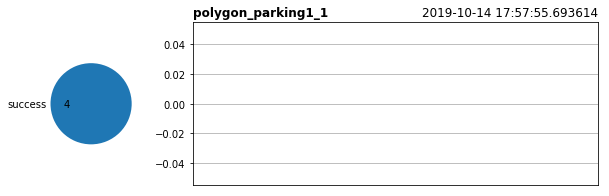

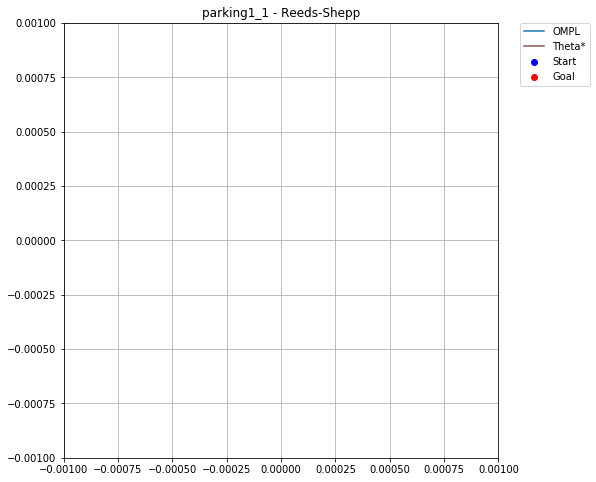

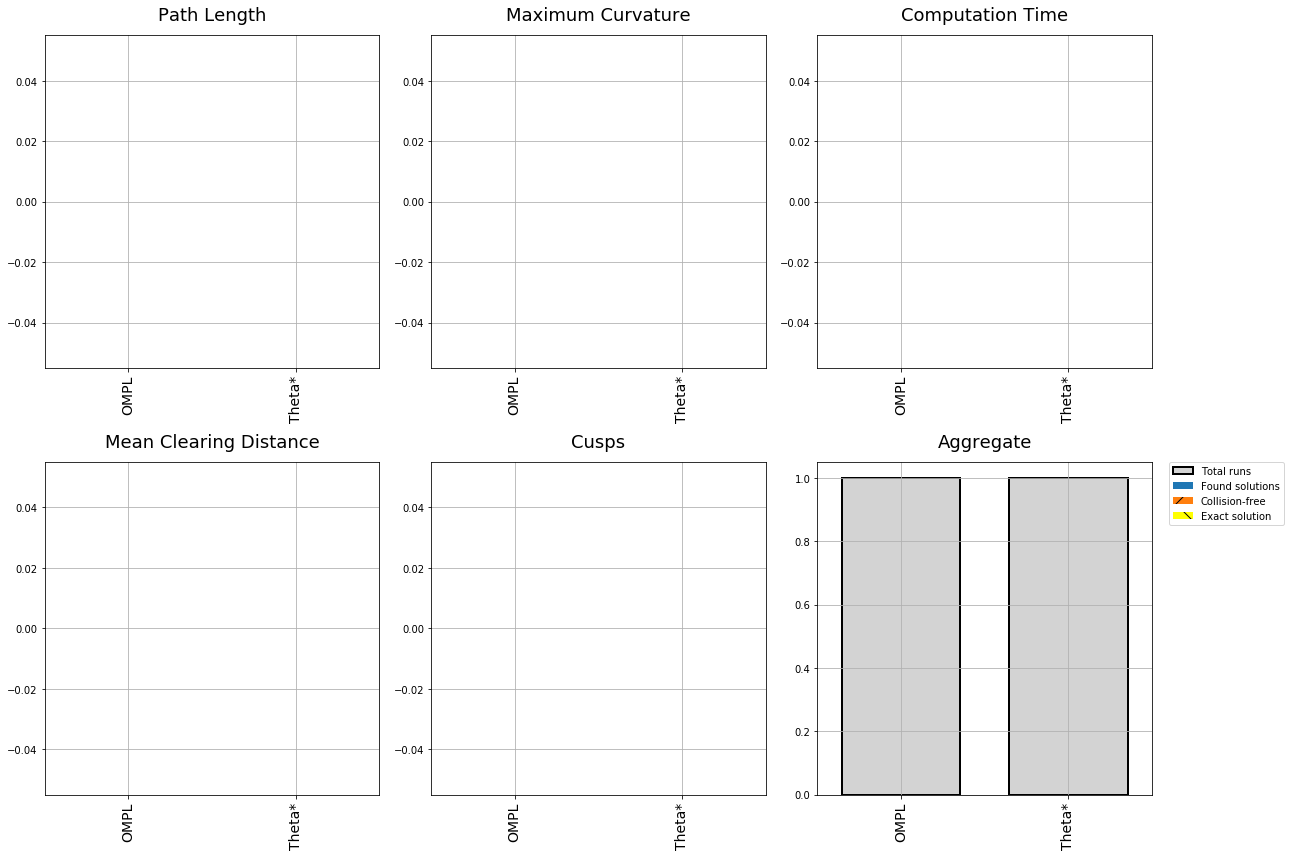

Visualizing polygon_parking1_1/polygon_parking1_1_1_results.json
Planner OMPL found no solution!
Planner Theta* found no solution!


Error while generating table: zero-size array to reduction operation maximum which has no identity


Visualizing polygon_parking1_1/polygon_parking1_1_1_results.json...
Saved polygon_parking1_1/polygon_parking1_1_dubins_stats.pdf.


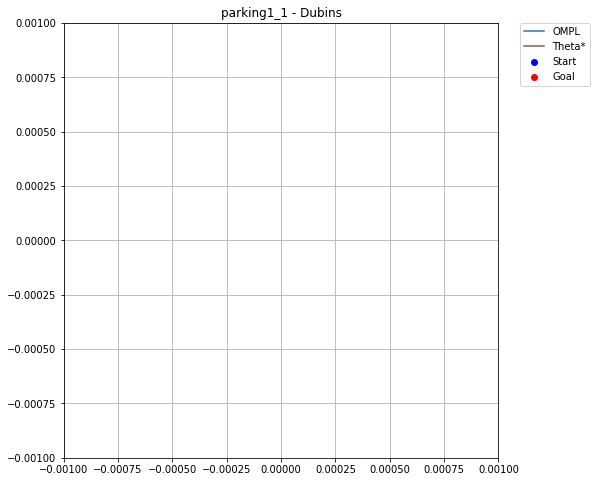

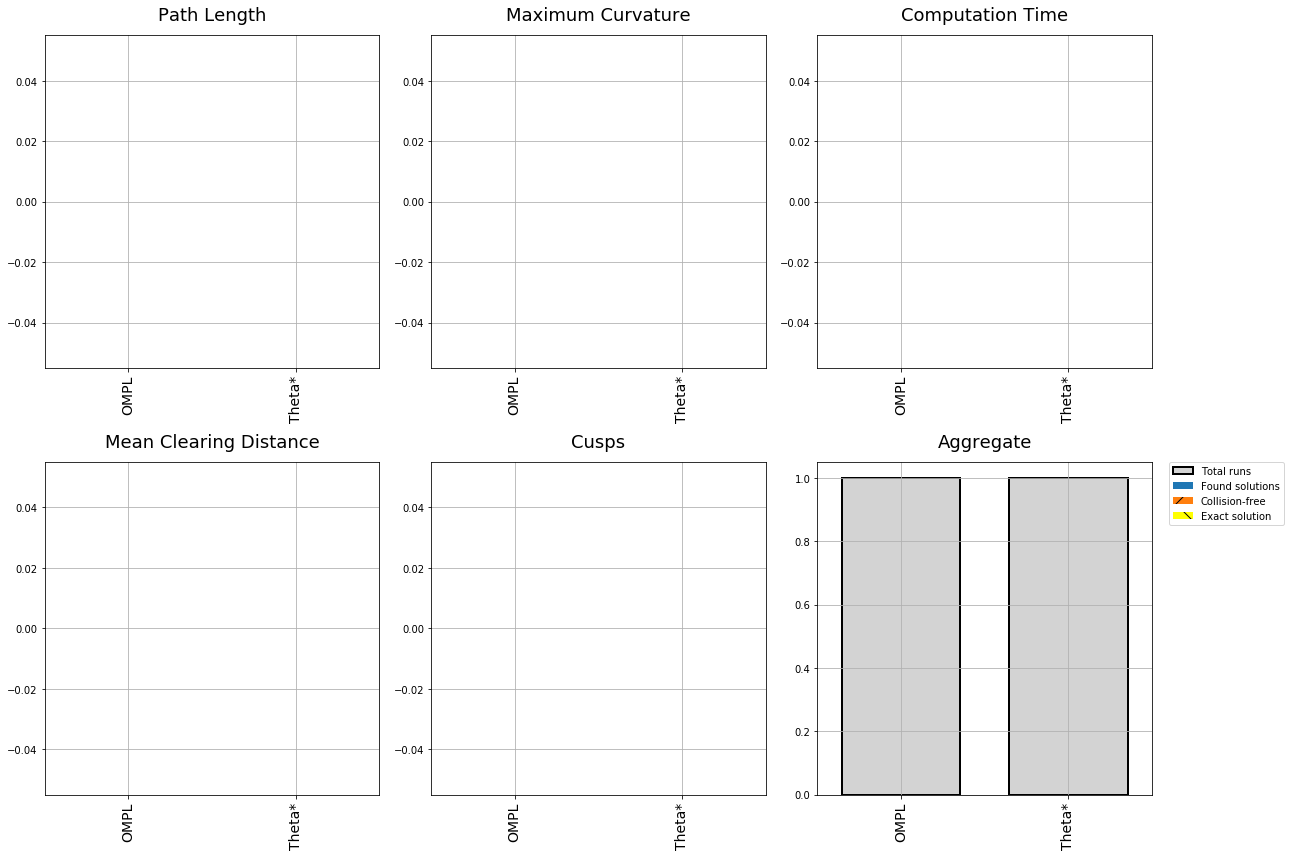

Visualizing polygon_parking1_1/polygon_parking1_1_2_results.json
Planner OMPL found no solution!
Planner Theta* found no solution!


Error while generating table: zero-size array to reduction operation maximum which has no identity


Visualizing polygon_parking1_1/polygon_parking1_1_2_results.json...
Saved polygon_parking1_1/polygon_parking1_1_cc_reeds_shepp_stats.pdf.


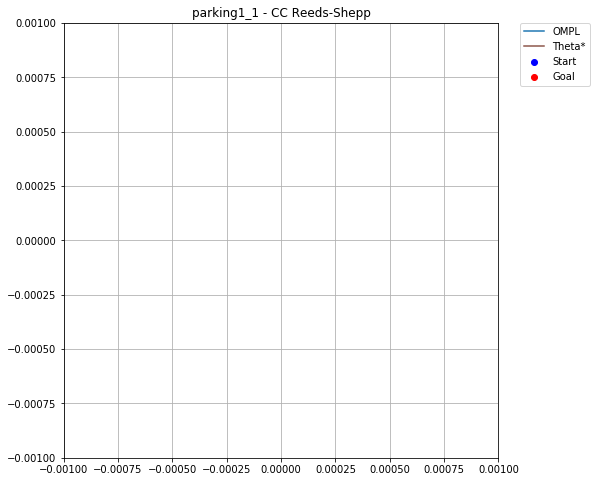

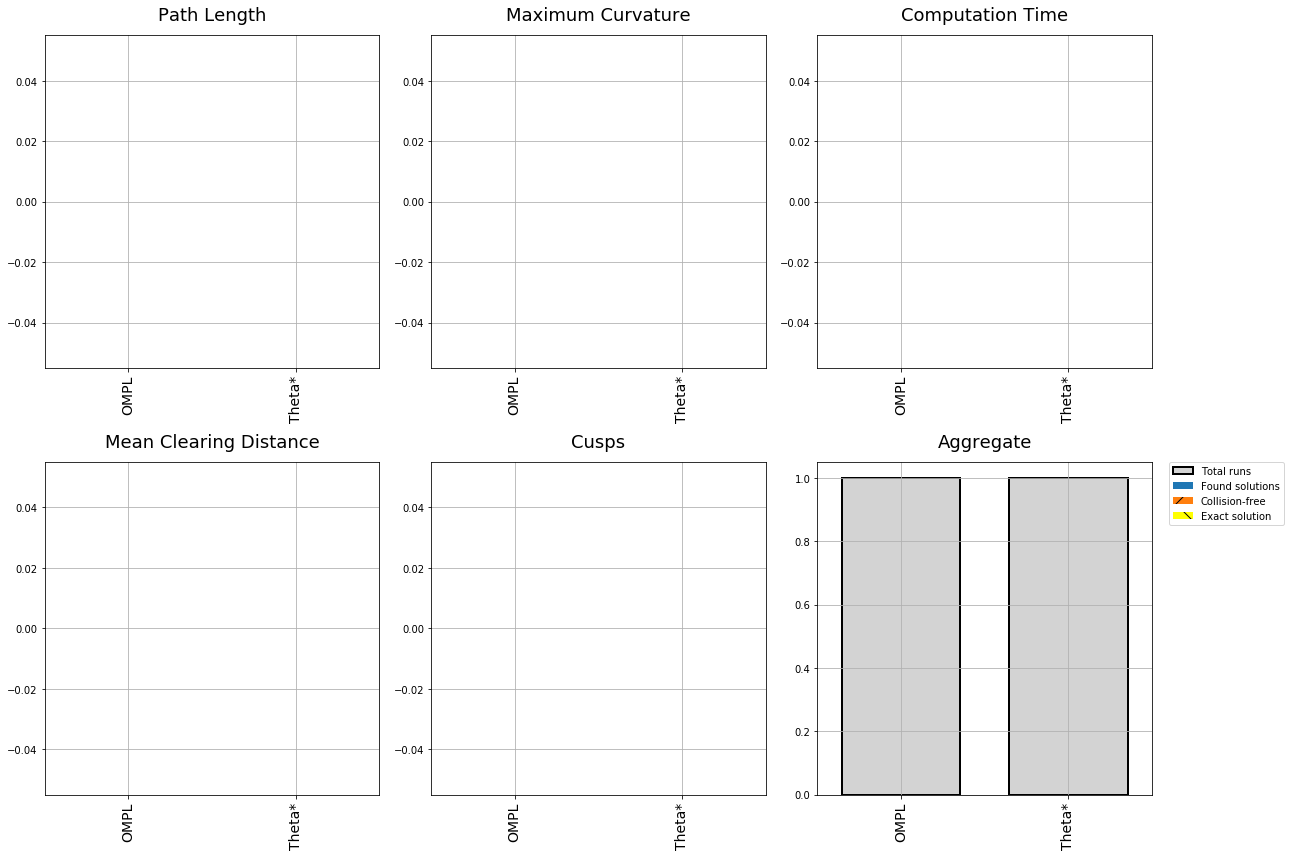

Visualizing polygon_parking1_1/polygon_parking1_1_3_results.json
Planner OMPL found no solution!
Planner Theta* found no solution!


Error while generating table: zero-size array to reduction operation maximum which has no identity


Visualizing polygon_parking1_1/polygon_parking1_1_3_results.json...
Saved polygon_parking1_1/polygon_parking1_1_posq_stats.pdf.


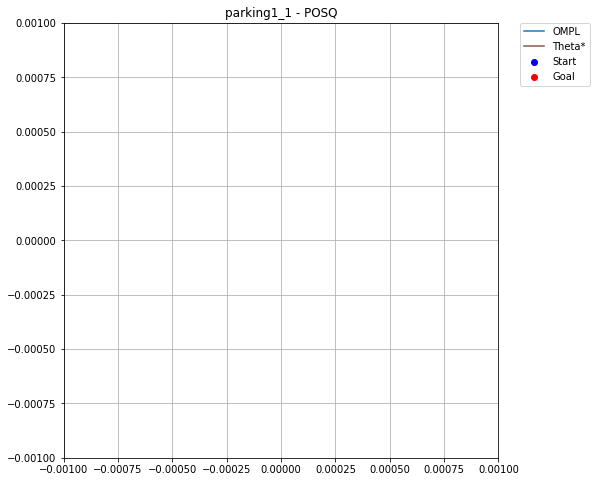

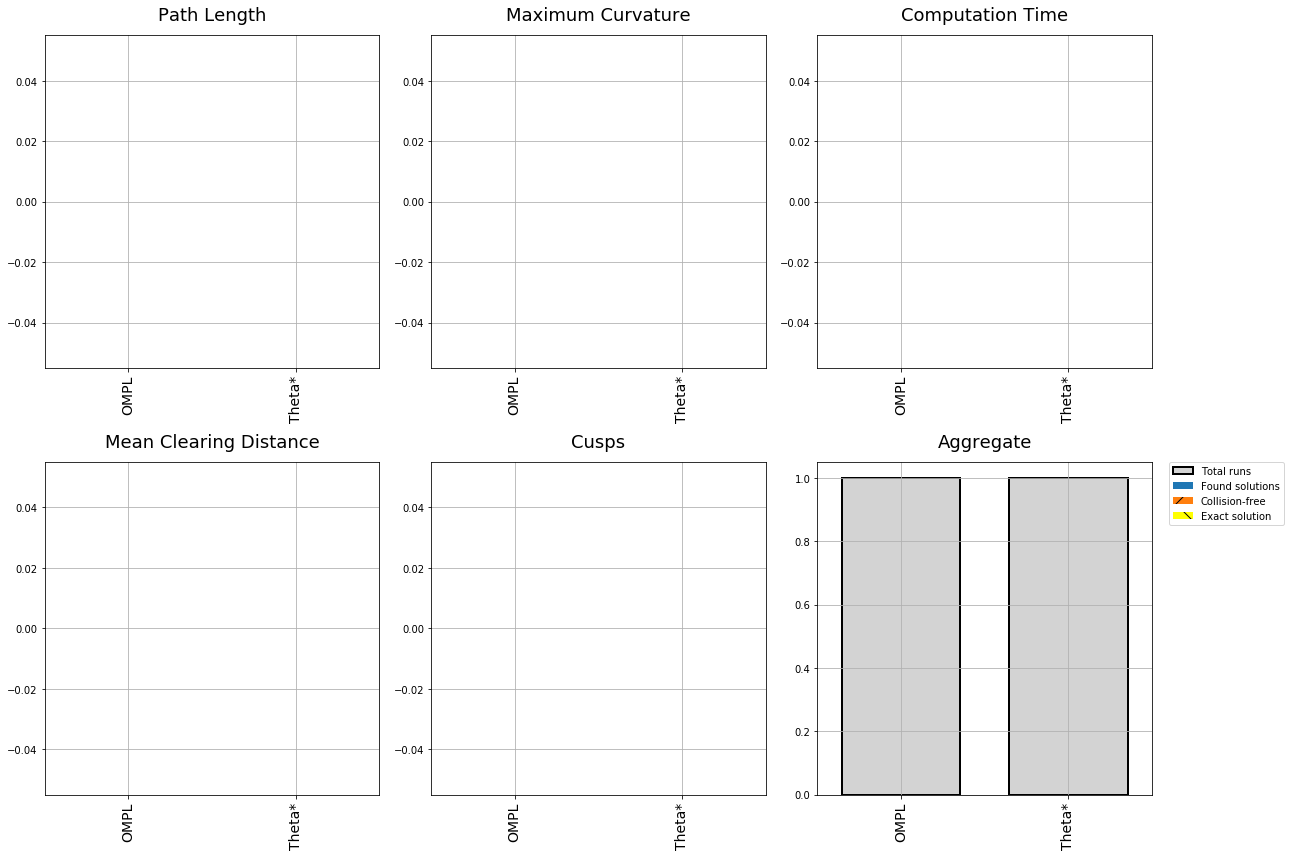

Available memory: 96.01 GB, limiting each MPB process to 6.9% usage (6.67 GB).
Creating pool of 4 processes.


Error while generating table: zero-size array to reduction operation maximum which has no identity


Created MPB from config polygon_parking1_2/polygon_parking1_2_2_config.json.
Created MPB from config polygon_parking1_2/polygon_parking1_2_3_config.json.
Created MPB from config polygon_parking1_2/polygon_parking1_2_1_config.json.
Created MPB from config polygon_parking1_2/polygon_parking1_2_0_config.json.
Running MPB with ID polygon_parking1_2_2 (log file at polygon_parking1_2/polygon_parking1_2_2.log)...
Running MPB with ID polygon_parking1_2_0 (log file at polygon_parking1_2/polygon_parking1_2_0.log)...
Running MPB with ID polygon_parking1_2_3 (log file at polygon_parking1_2/polygon_parking1_2_3.log)...
Running MPB with ID polygon_parking1_2_1 (log file at polygon_parking1_2/polygon_parking1_2_1.log)...



Benchmark 1 (polygon_parking1_2_1) finished successfully.


Benchmark 2 (polygon_parking1_2_2) finished successfully.

Benchmark 0 (polygon_parking1_2_0) finished successfully.
Benchmark 3 (polygon_parking1_2_3) finished successfully.
All benchmarks succeeded.
Visualizing polygon_parking1_2/polygon_parking1_2_0_results.json
Planner OMPL found no solution!
Planner Theta* found no solution!


Error while plotting benchmark progress overview.


Visualizing polygon_parking1_2/polygon_parking1_2_0_results.json...
Saved polygon_parking1_2/polygon_parking1_2_reeds_shepp_stats.pdf.


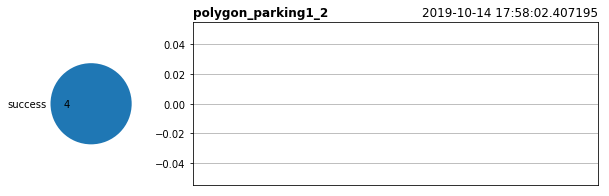

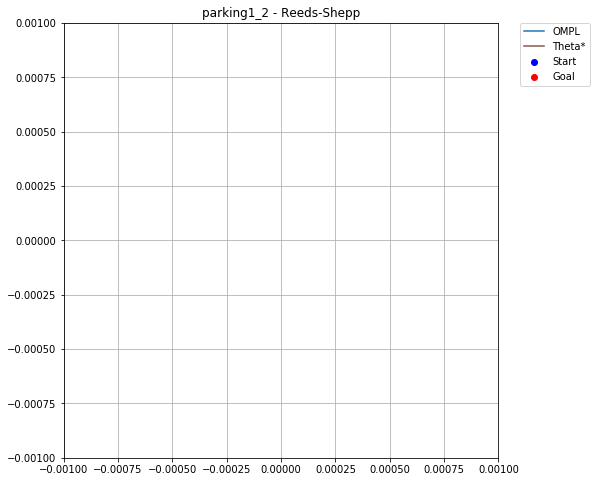

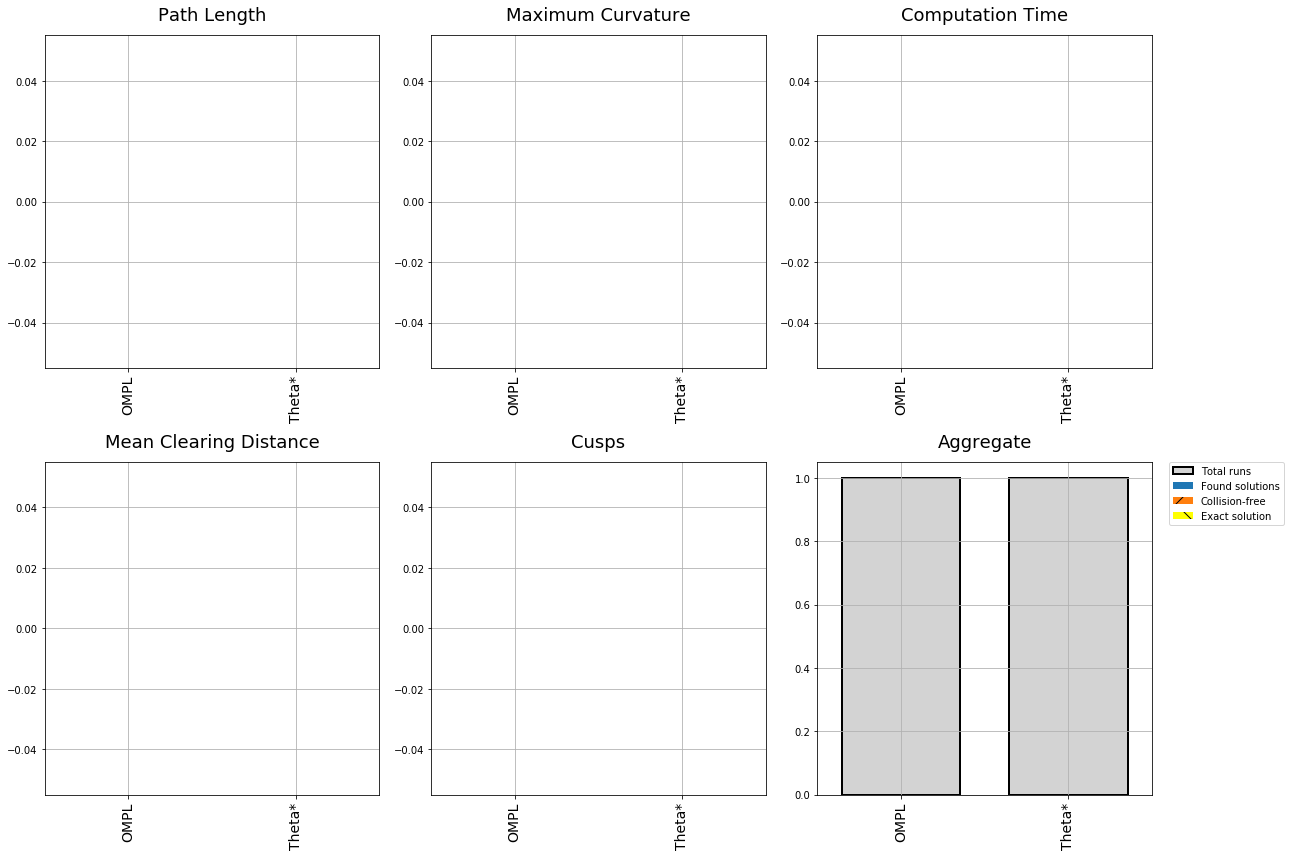

Visualizing polygon_parking1_2/polygon_parking1_2_1_results.json
Planner OMPL found no solution!
Planner Theta* found no solution!


Error while generating table: zero-size array to reduction operation maximum which has no identity


Visualizing polygon_parking1_2/polygon_parking1_2_1_results.json...
Saved polygon_parking1_2/polygon_parking1_2_dubins_stats.pdf.


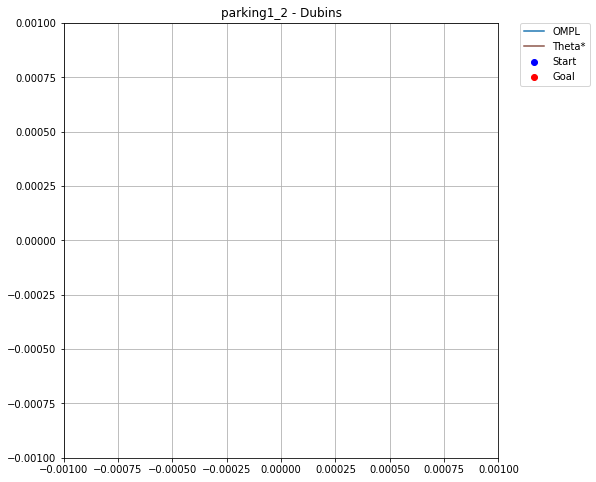

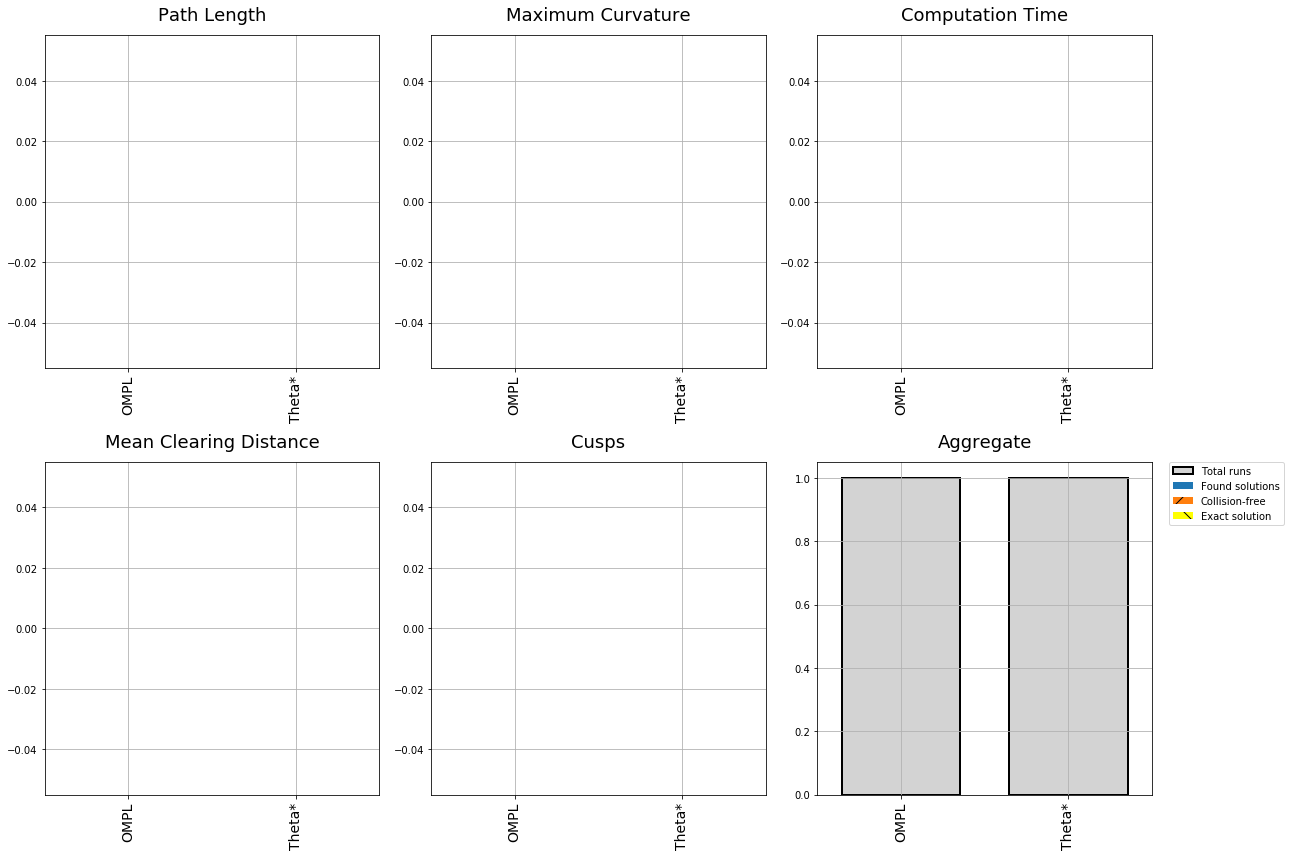

Visualizing polygon_parking1_2/polygon_parking1_2_2_results.json
Planner OMPL found no solution!
Planner Theta* found no solution!


Error while generating table: zero-size array to reduction operation maximum which has no identity


Visualizing polygon_parking1_2/polygon_parking1_2_2_results.json...
Saved polygon_parking1_2/polygon_parking1_2_cc_reeds_shepp_stats.pdf.


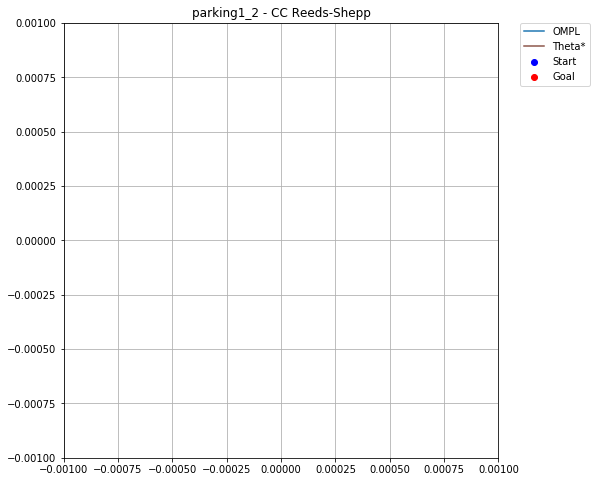

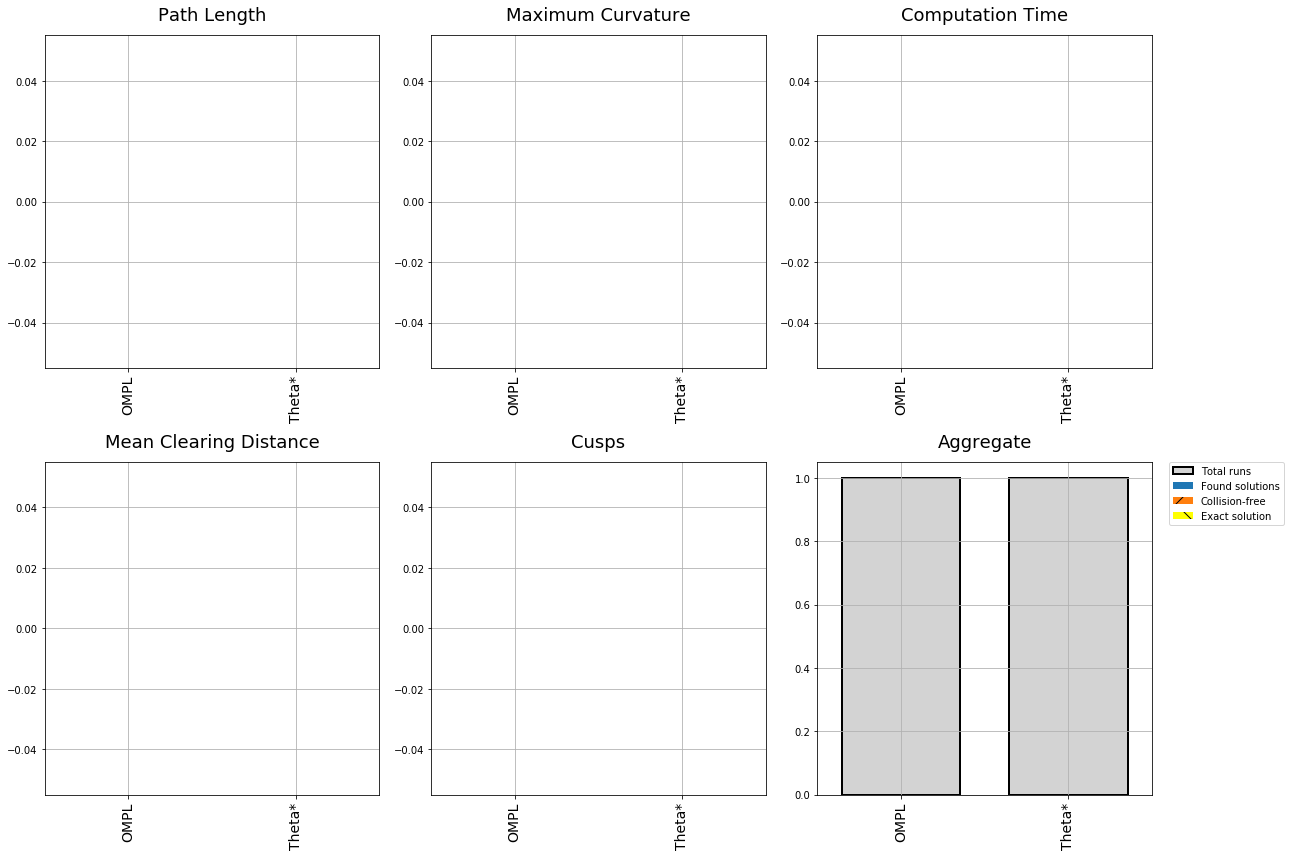

Visualizing polygon_parking1_2/polygon_parking1_2_3_results.json
Planner OMPL found no solution!
Planner Theta* found no solution!


Error while generating table: zero-size array to reduction operation maximum which has no identity


Visualizing polygon_parking1_2/polygon_parking1_2_3_results.json...
Saved polygon_parking1_2/polygon_parking1_2_posq_stats.pdf.


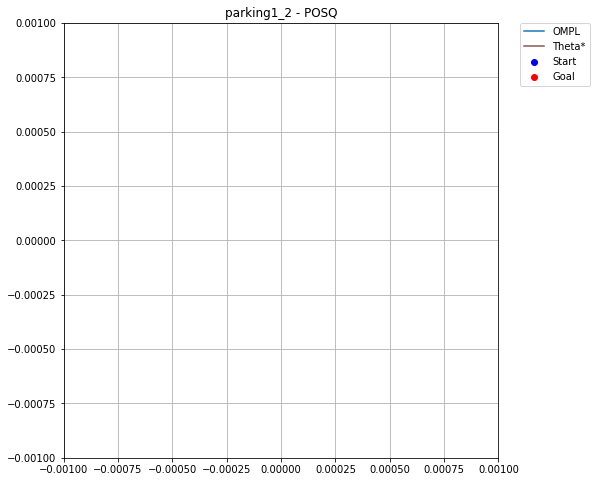

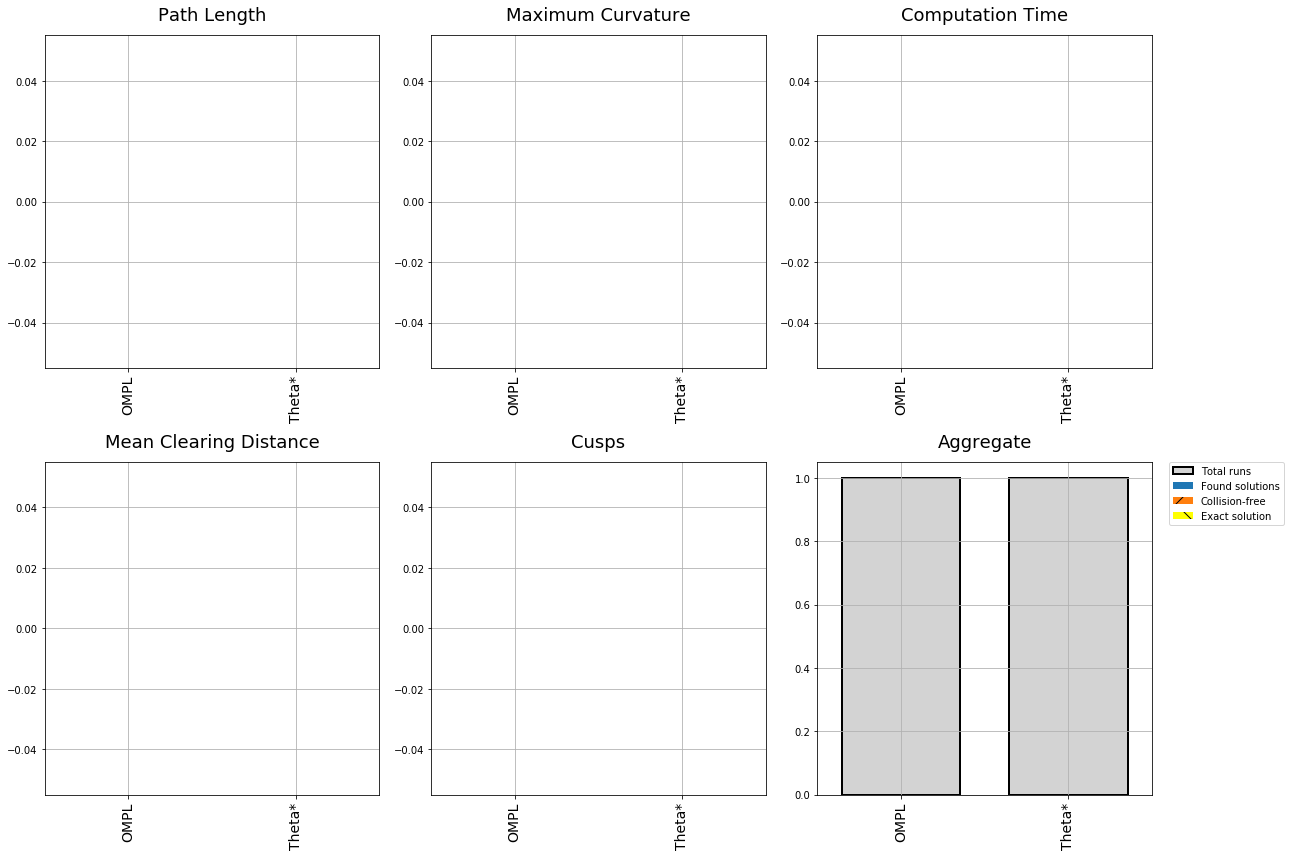

Available memory: 96.01 GB, limiting each MPB process to 6.9% usage (6.67 GB).
Creating pool of 4 processes.


Error while generating table: zero-size array to reduction operation maximum which has no identity


Created MPB from config polygon_parking1_3/polygon_parking1_3_1_config.json.
Created MPB from config polygon_parking1_3/polygon_parking1_3_0_config.json.
Created MPB from config polygon_parking1_3/polygon_parking1_3_2_config.json.
Created MPB from config polygon_parking1_3/polygon_parking1_3_3_config.json.
Running MPB with ID polygon_parking1_3_0 (log file at polygon_parking1_3/polygon_parking1_3_0.log)...
Running MPB with ID polygon_parking1_3_1 (log file at polygon_parking1_3/polygon_parking1_3_1.log)...
Running MPB with ID polygon_parking1_3_2 (log file at polygon_parking1_3/polygon_parking1_3_2.log)...
Running MPB with ID polygon_parking1_3_3 (log file at polygon_parking1_3/polygon_parking1_3_3.log)...



Benchmark 1 (polygon_parking1_3_1) finished successfully.

Benchmark 3 (polygon_parking1_3_3) finished successfully.

Benchmark 2 (polygon_parking1_3_2) finished successfully.

Benchmark 0 (polygon_parking1_3_0) finished successfully.
All benchmarks succeeded.
Visualizing polygon_parking1_3/polygon_parking1_3_0_results.json
Planner OMPL found no solution!
Planner Theta* found no solution!


Error while plotting benchmark progress overview.


Visualizing polygon_parking1_3/polygon_parking1_3_0_results.json...
Saved polygon_parking1_3/polygon_parking1_3_reeds_shepp_stats.pdf.


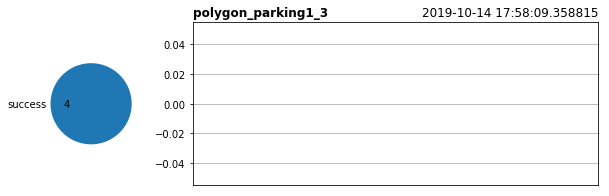

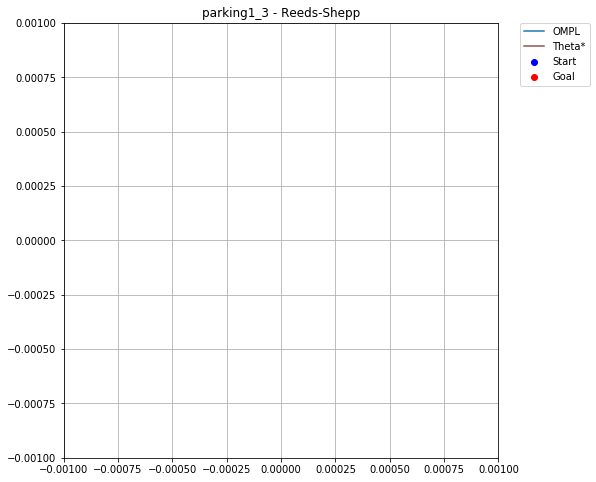

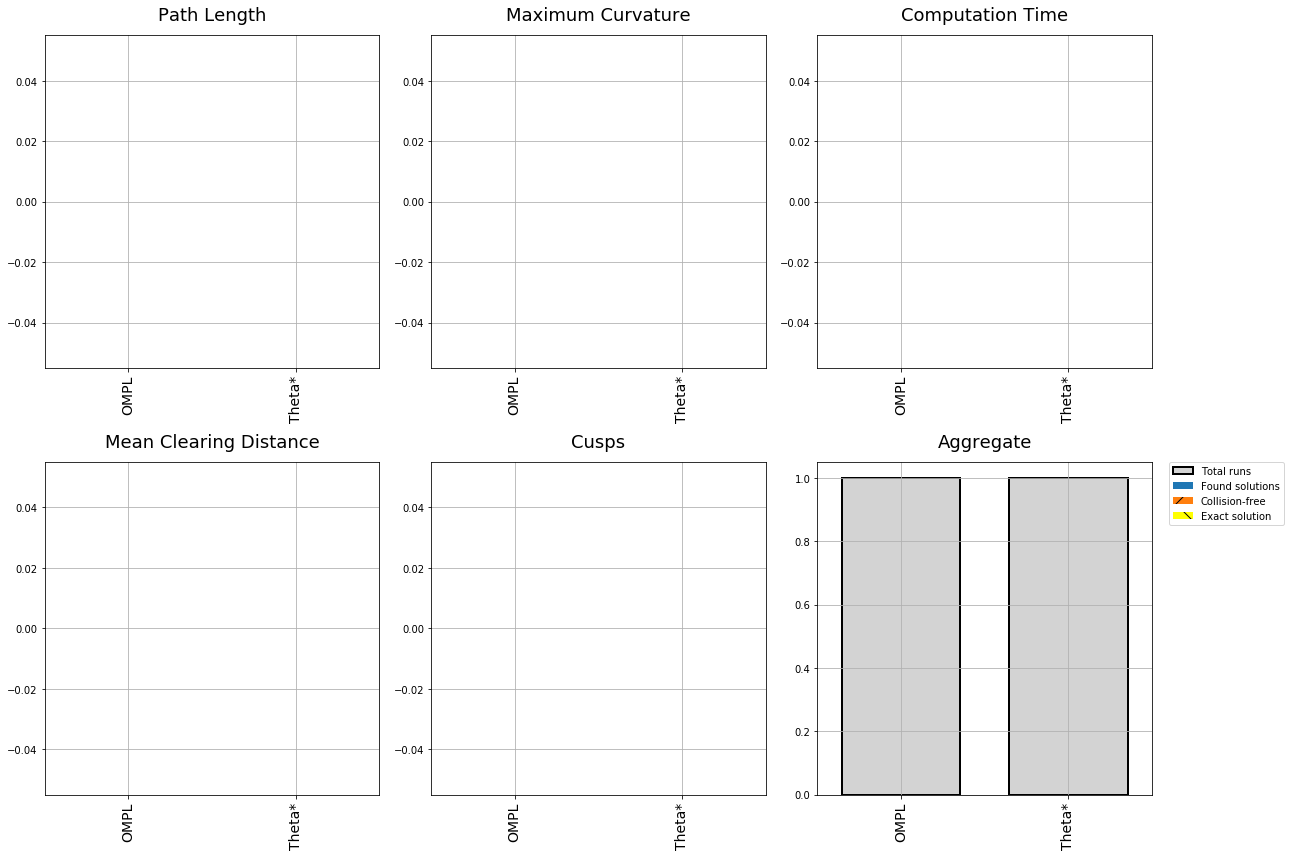

Visualizing polygon_parking1_3/polygon_parking1_3_1_results.json
Planner OMPL found no solution!
Planner Theta* found no solution!


Error while generating table: zero-size array to reduction operation maximum which has no identity


Visualizing polygon_parking1_3/polygon_parking1_3_1_results.json...
Saved polygon_parking1_3/polygon_parking1_3_dubins_stats.pdf.


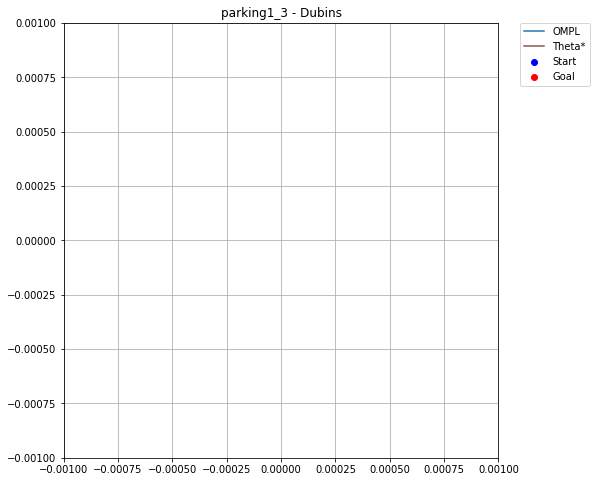

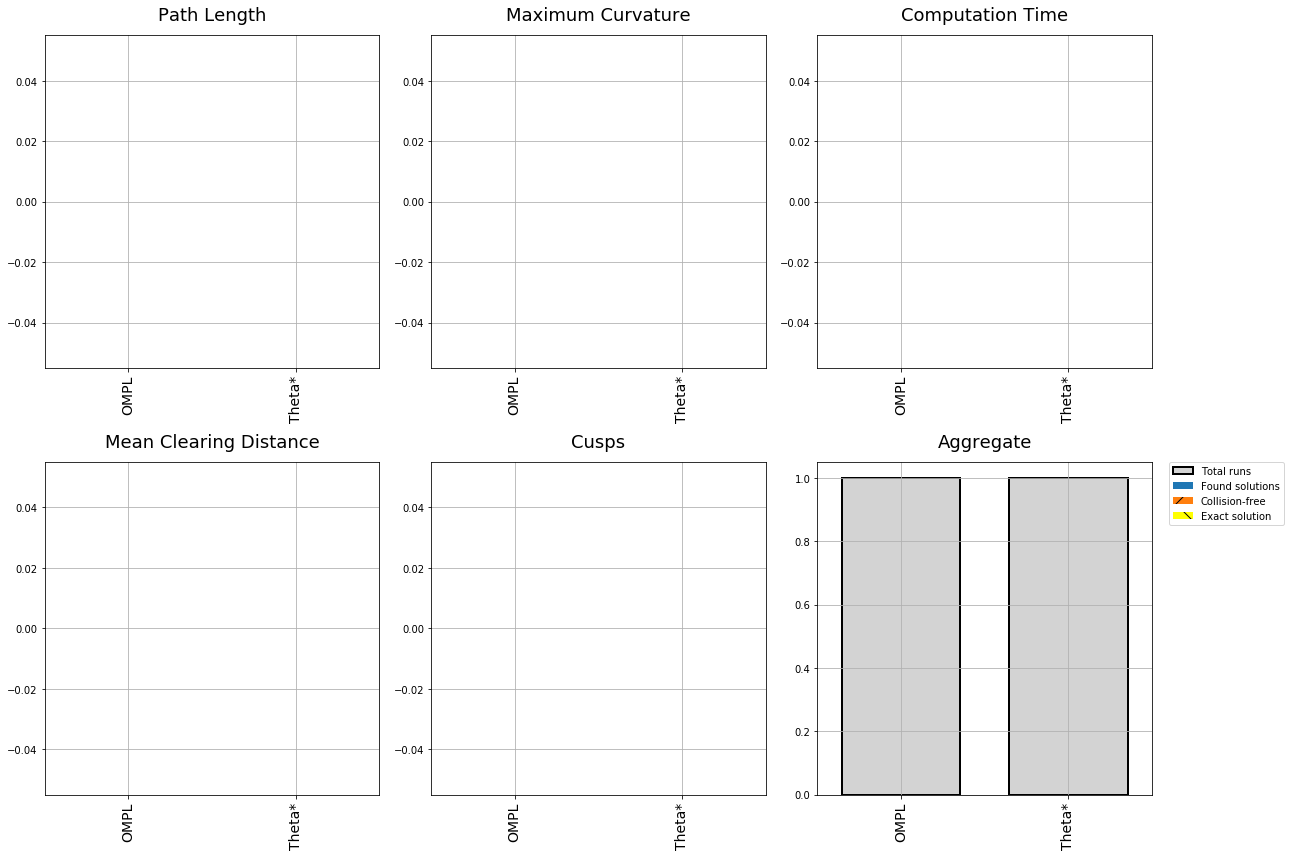

Visualizing polygon_parking1_3/polygon_parking1_3_2_results.json
Planner OMPL found no solution!
Planner Theta* found no solution!


Error while generating table: zero-size array to reduction operation maximum which has no identity


Visualizing polygon_parking1_3/polygon_parking1_3_2_results.json...
Saved polygon_parking1_3/polygon_parking1_3_cc_reeds_shepp_stats.pdf.


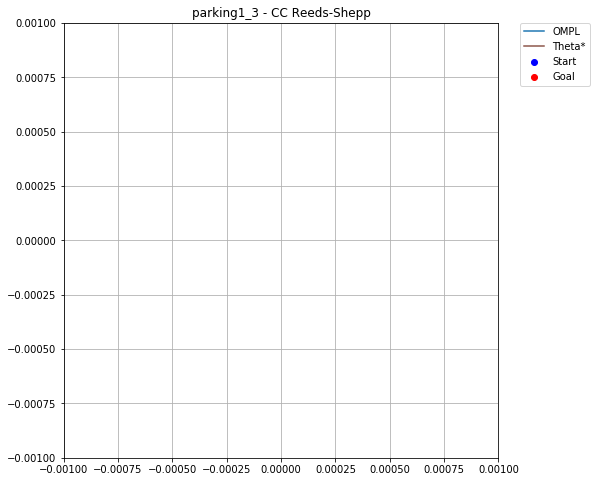

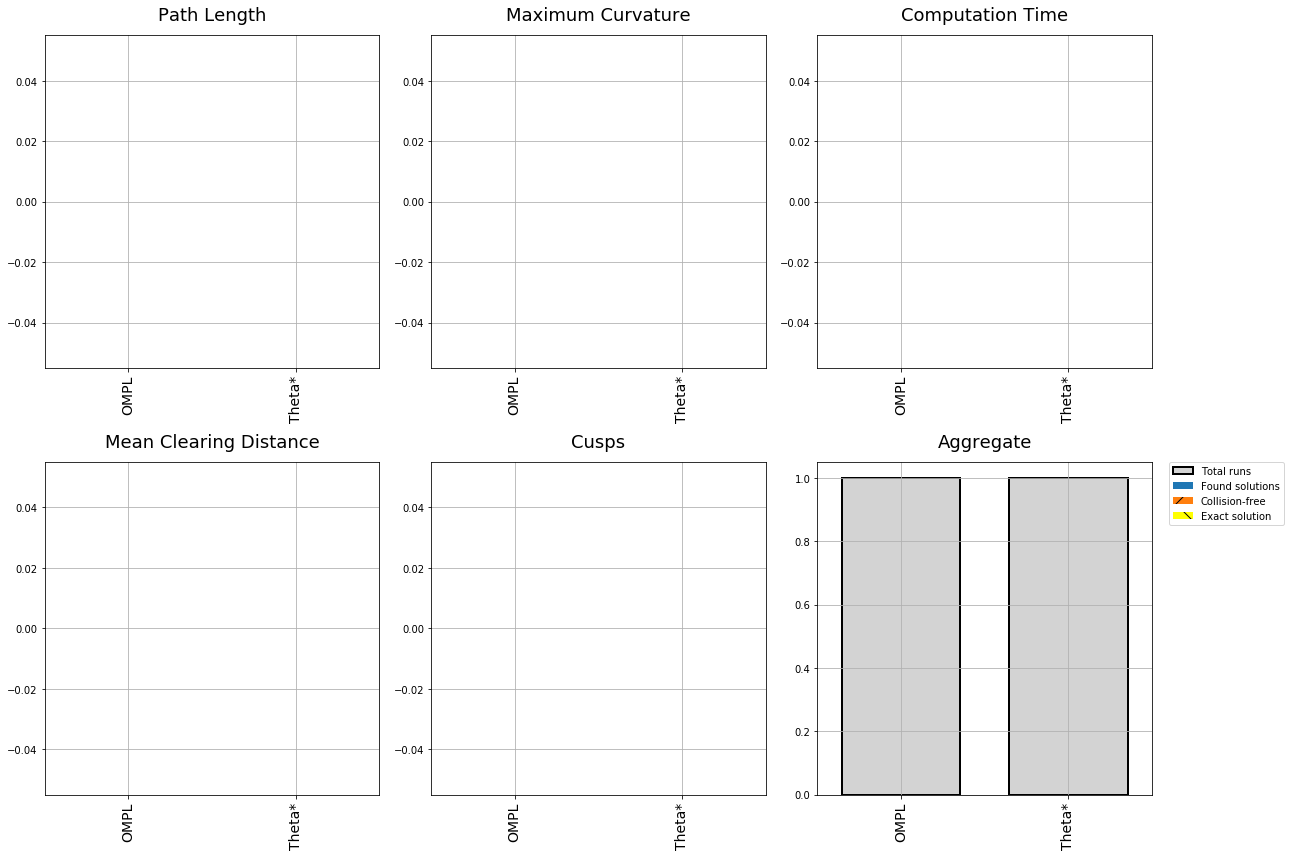

Visualizing polygon_parking1_3/polygon_parking1_3_3_results.json
Planner OMPL found no solution!
Planner Theta* found no solution!


Error while generating table: zero-size array to reduction operation maximum which has no identity


Visualizing polygon_parking1_3/polygon_parking1_3_3_results.json...
Saved polygon_parking1_3/polygon_parking1_3_posq_stats.pdf.


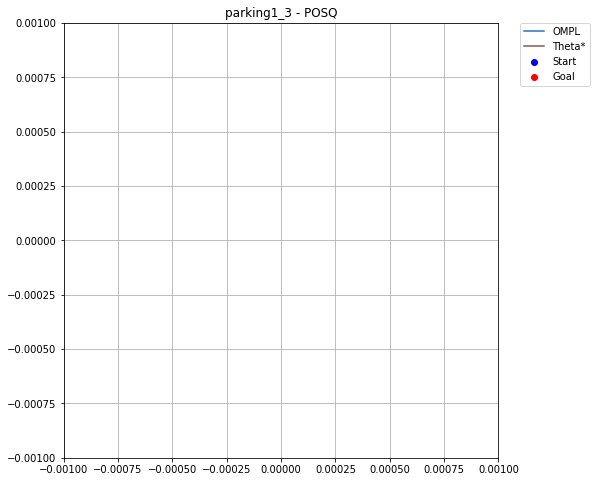

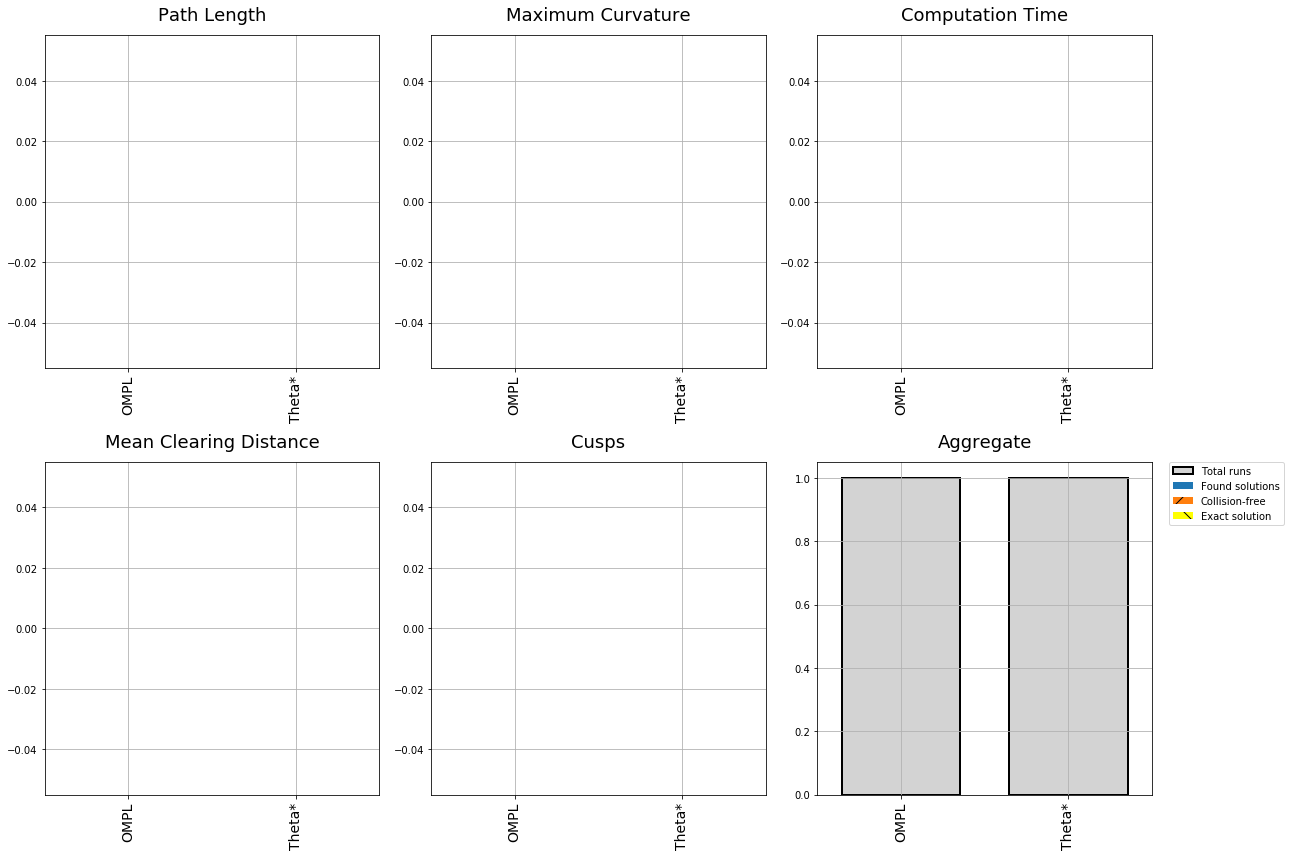

Available memory: 96.01 GB, limiting each MPB process to 6.9% usage (6.67 GB).
Creating pool of 4 processes.


Error while generating table: zero-size array to reduction operation maximum which has no identity


Created MPB from config polygon_parking1_4/polygon_parking1_4_1_config.json.
Created MPB from config polygon_parking1_4/polygon_parking1_4_3_config.json.
Created MPB from config polygon_parking1_4/polygon_parking1_4_0_config.json.
Created MPB from config polygon_parking1_4/polygon_parking1_4_2_config.json.
Running MPB with ID polygon_parking1_4_1 (log file at polygon_parking1_4/polygon_parking1_4_1.log)...
Running MPB with ID polygon_parking1_4_3 (log file at polygon_parking1_4/polygon_parking1_4_3.log)...
Running MPB with ID polygon_parking1_4_2 (log file at polygon_parking1_4/polygon_parking1_4_2.log)...
Running MPB with ID polygon_parking1_4_0 (log file at polygon_parking1_4/polygon_parking1_4_0.log)...




Benchmark 1 (polygon_parking1_4_1) finished successfully.

Benchmark 0 (polygon_parking1_4_0) finished successfully.
Benchmark 2 (polygon_parking1_4_2) finished successfully.

Benchmark 3 (polygon_parking1_4_3) finished successfully.
All benchmarks succeeded.
Visualizing polygon_parking1_4/polygon_parking1_4_0_results.json
Planner OMPL found no solution!
Planner Theta* found no solution!


Error while plotting benchmark progress overview.


Visualizing polygon_parking1_4/polygon_parking1_4_0_results.json...
Saved polygon_parking1_4/polygon_parking1_4_reeds_shepp_stats.pdf.


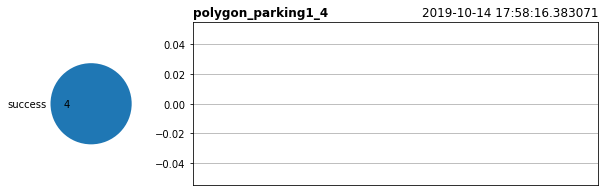

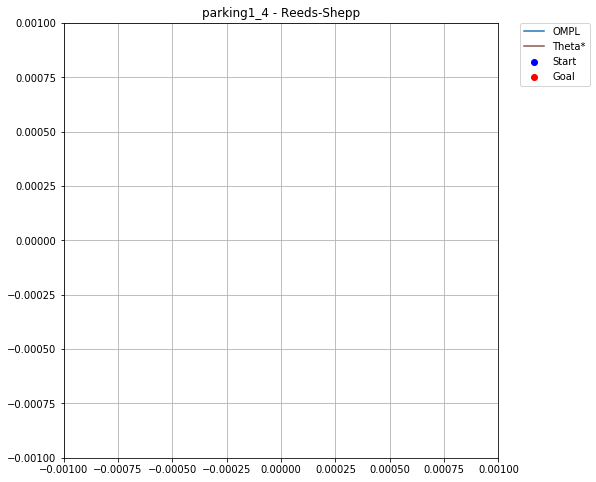

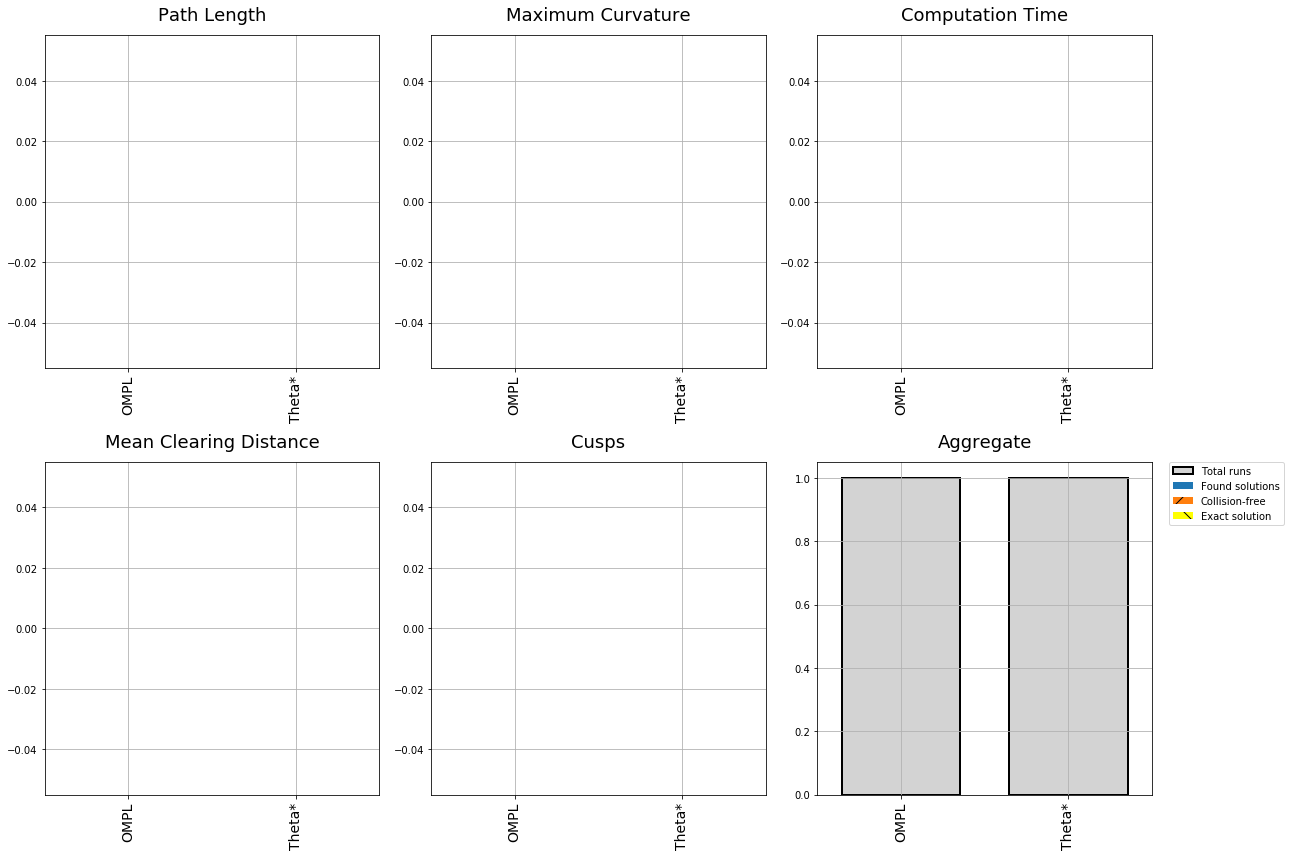

Visualizing polygon_parking1_4/polygon_parking1_4_1_results.json
Planner OMPL found no solution!
Planner Theta* found no solution!


Error while generating table: zero-size array to reduction operation maximum which has no identity


Visualizing polygon_parking1_4/polygon_parking1_4_1_results.json...
Saved polygon_parking1_4/polygon_parking1_4_dubins_stats.pdf.


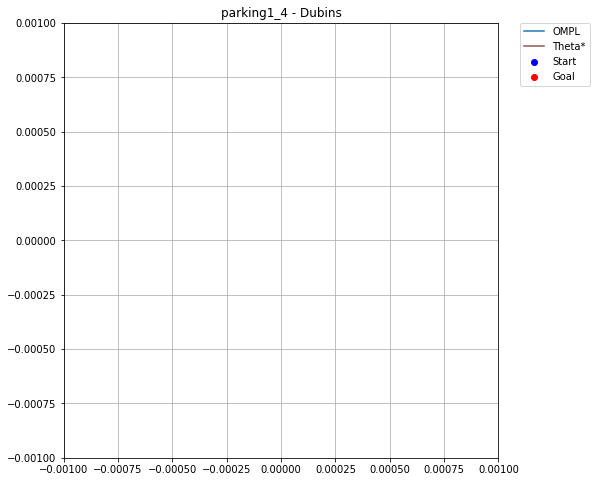

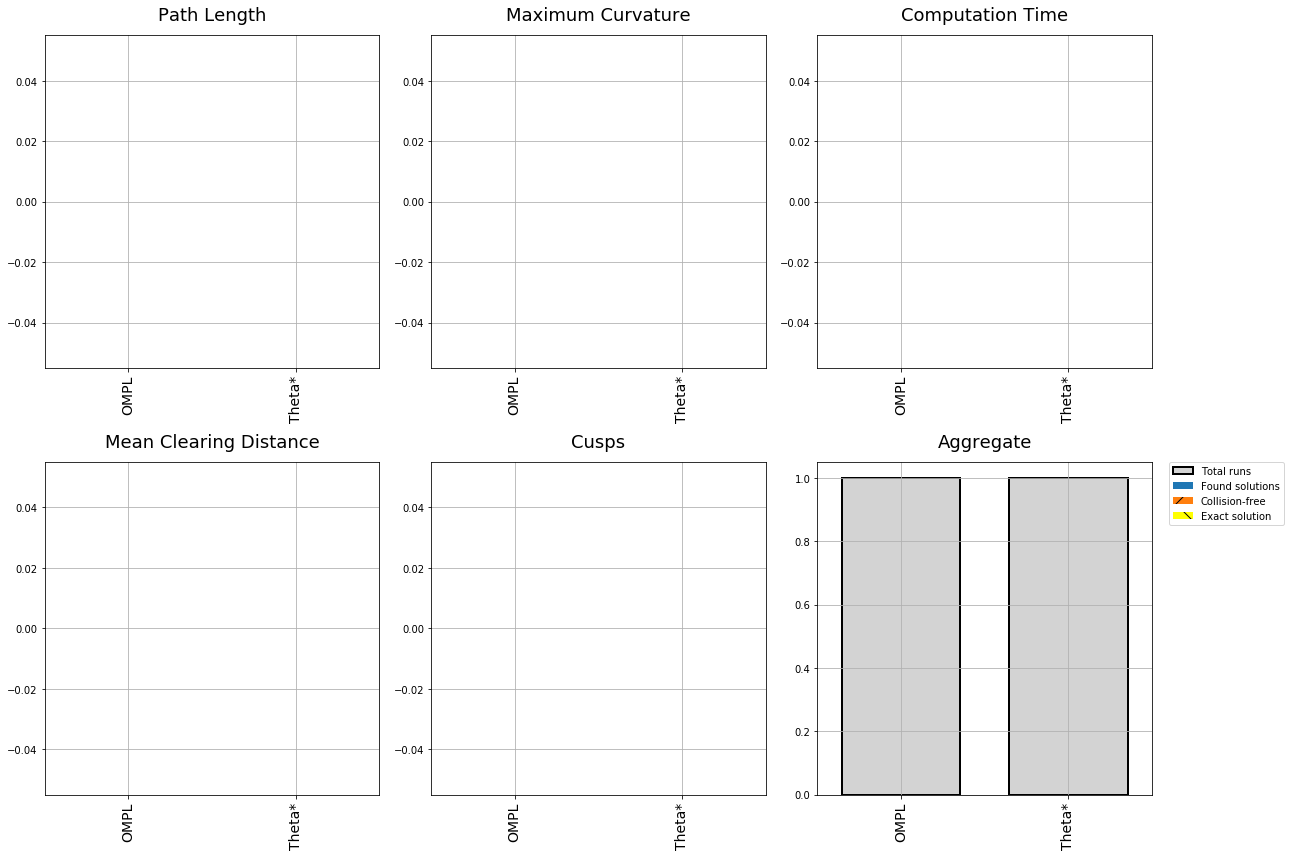

Visualizing polygon_parking1_4/polygon_parking1_4_2_results.json
Planner OMPL found no solution!
Planner Theta* found no solution!


Error while generating table: zero-size array to reduction operation maximum which has no identity


Visualizing polygon_parking1_4/polygon_parking1_4_2_results.json...
Saved polygon_parking1_4/polygon_parking1_4_cc_reeds_shepp_stats.pdf.


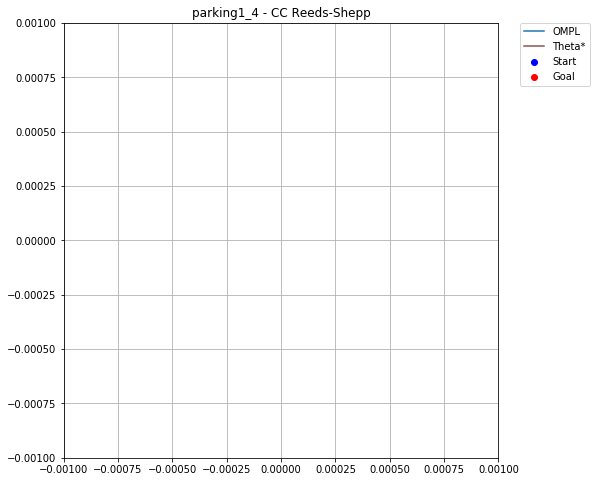

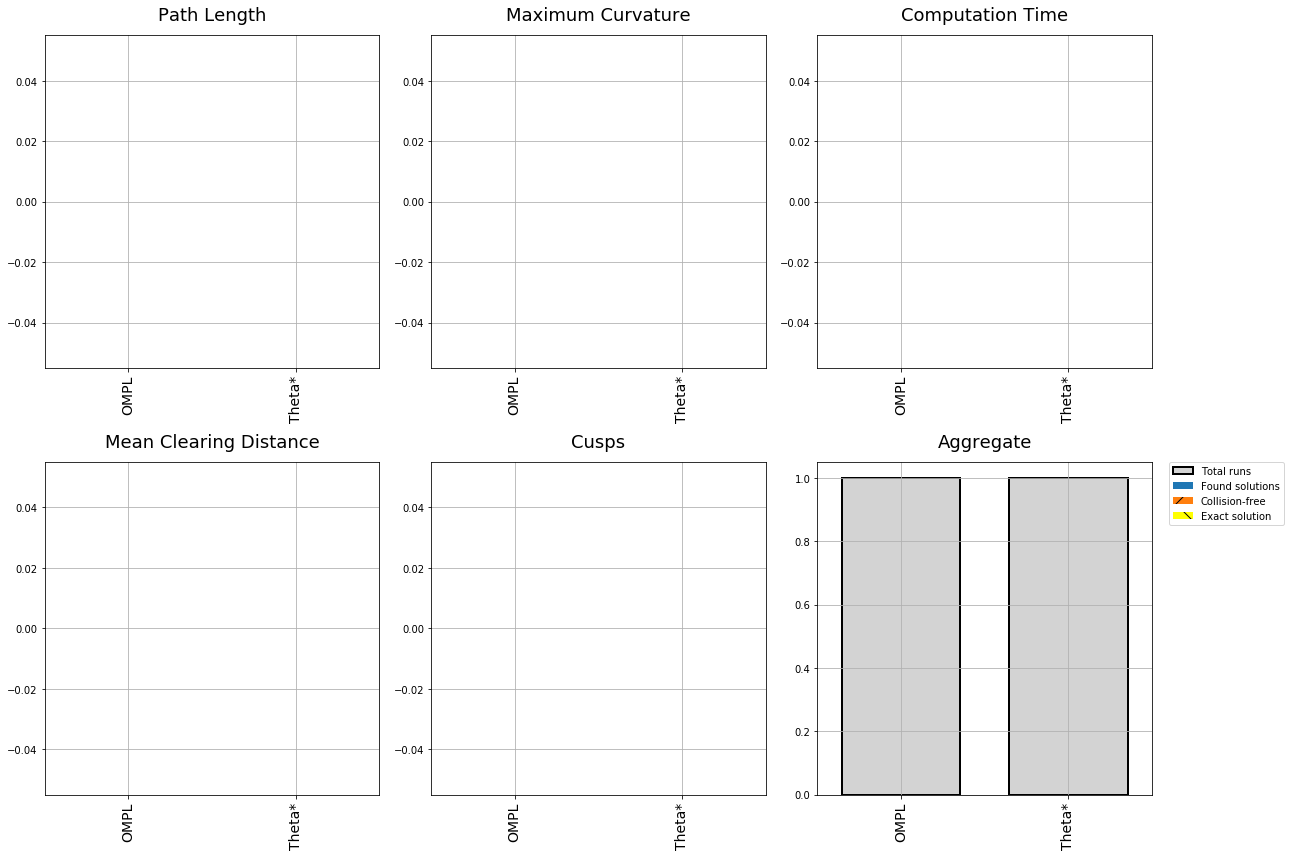

Visualizing polygon_parking1_4/polygon_parking1_4_3_results.json
Planner OMPL found no solution!
Planner Theta* found no solution!


Error while generating table: zero-size array to reduction operation maximum which has no identity


Visualizing polygon_parking1_4/polygon_parking1_4_3_results.json...


KeyboardInterrupt: 

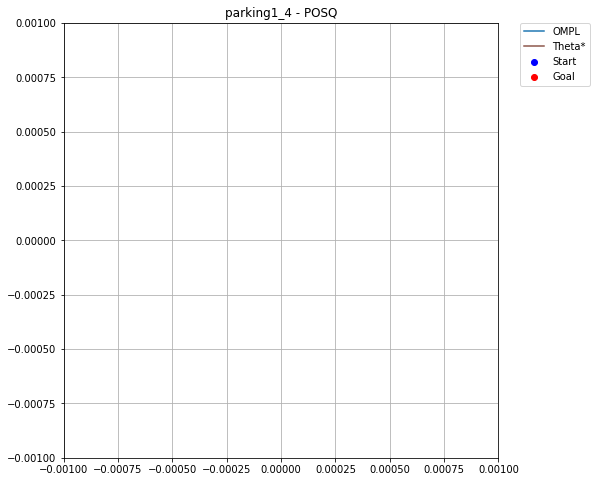

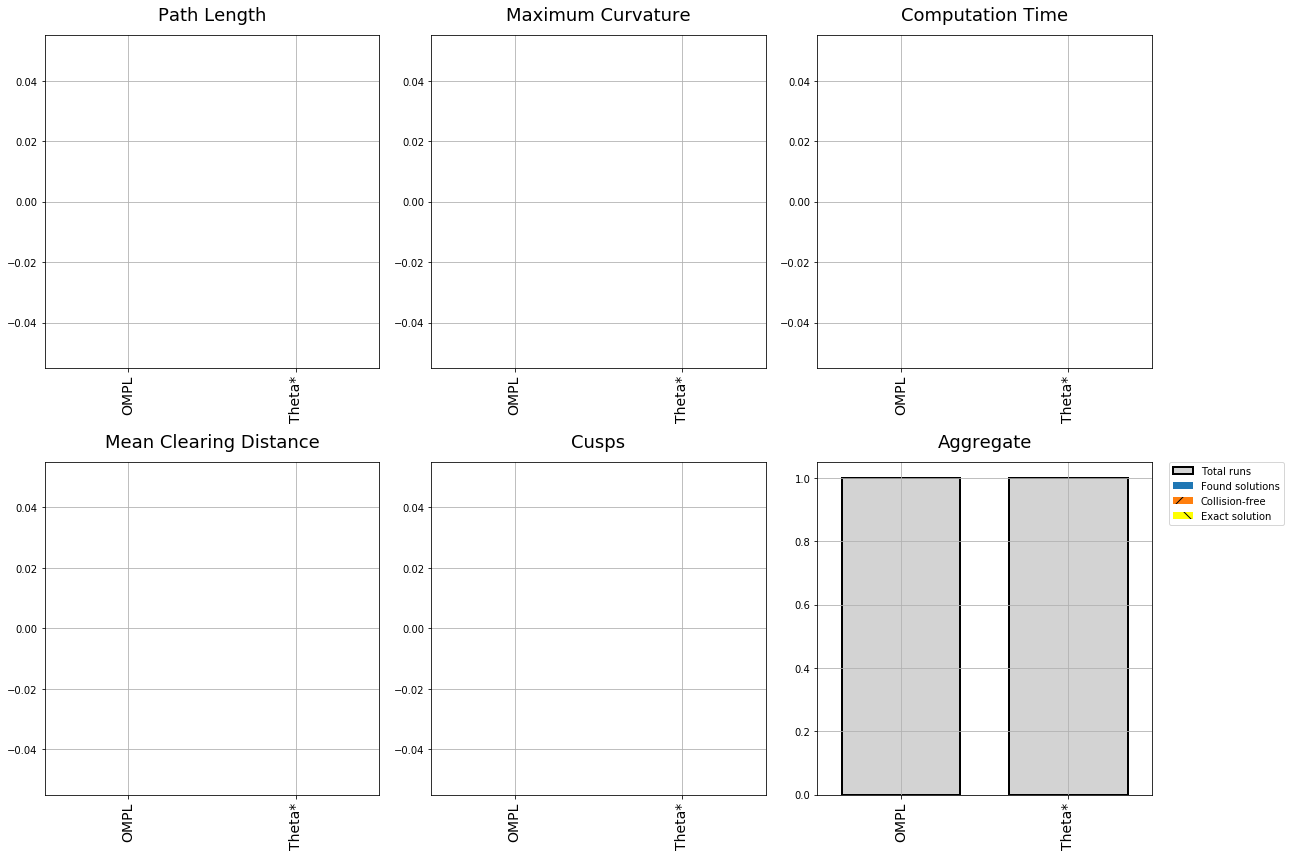

In [63]:
scenarios = [
    (
        "parking1", [
            ({"theta": 0, "x": 0, "y": -2.27}, {"theta": -1.58, "x": 7.72, "y": -7.72}),
            ({"theta": -1.58, "x": 7.72, "y": -7.72}, {"theta": 3.14, "x": 0, "y": -2.27}),
            ({"theta": -1.58, "x": 7.72, "y": -7.72}, {"theta": 1.58, "x": 10, "y": -7.72}),
            ({"theta": -1.58, "x": 7.72, "y": -7.72}, {"theta": 0, "x": 15, "y": -2.27}),
            ({"theta": 3.14, "x": 15, "y": -2.27}, {"theta": -1.58, "x": 7.72, "y": -7.72}),
        ]
    ), (
        "parking2", [
            ({"theta": 0, "x": 0, "y": -2.27}, {"theta": 1.57, "x": 10.91, "y": 2.73}),
            ({"theta": 1.57, "x": 10.91, "y": 2.73}, {"theta": 3.14, "x": 0, "y": -2.27}),
            ({"theta": 0, "x": 0, "y": -2.27}, {"theta": 1.57, "x": 13.5, "y": -7}),
            ({"theta": 1.57, "x": 13.5, "y": -7}, {"theta": 3.14, "x": 0, "y": -2.27}),
            ({"theta": 1.57, "x": 13.5, "y": -7}, {"theta": 1.57, "x": 10.91, "y": 2.73}),
        ]
    ), (
        "parking3", [
            ({"theta": 0, "x": 15.45, "y": -2.27}, {"theta": 0, "x": 3.4, "y": 0.34}),
            ({"theta": 0, "x": 5, "y": -2.27}, {"theta": 0, "x": 19.5, "y": -6}),
            ({"theta": 3.14, "x": 19.5, "y": -6}, {"theta": 3.14, "x": 5, "y": -2.27}),
            ({"theta": 3.14, "x": 19.5, "y": -2.5}, {"theta": 3.14, "x": 4.5, "y": 0.5}),
            ({"theta": 0, "x": 4.5, "y": 0.5}, {"theta": 0, "x": 19.5, "y": -2.5}),
        ]
    ), (
        "warehouse", [
            ({"theta": -1.58, "x": -2.5, "y": 4.55}, {"theta": -1.58, "x": 65, "y": 2.5}, "polygon_mazes/warehouse_robot.svg"),
            ({"theta": 0, "x": -2.5, "y": -55}, {"theta": 0, "x": 55, "y": 5.5}, "polygon_mazes/warehouse_robot.svg"),
            ({"theta": 1.58, "x": 14.5, "y": -28}, {"theta": 1.58, "x": 48, "y": -28}, "polygon_mazes/warehouse_robot.svg"),
            ({"theta": 3.14, "x": 65, "y": -55}, {"theta": 1.58, "x": 14.5, "y": 0}, "polygon_mazes/warehouse_robot.svg"),
            ({"theta": 3.14, "x": 3, "y": -5}, {"theta": 1.58, "x": 66, "y": -5}, "polygon_mazes/warehouse_robot.svg"),
        ]
    )
]

for i, (env, args) in enumerate(scenarios):
    for j, arg in enumerate(args):
        scenario = "%s_%i" % (env, j)
        benchmark_polygon(scenario, *arg)
        generate_plots(scenario, *arg)

In [ ]:
list(map(lambda x: generate_plots(*x), scenarios))